# Develop a model of biological aging using Jax to predict syllable usage

In [1]:
import jax
import optax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import tensorflow_probability.substrates.jax as tfp
import matplotlib.pyplot as plt
import seaborn as sns
from toolz import partial
from statsmodels.gam.smooth_basis import BSplines
from aging.plotting import format_plots, figure, legend
from aging.behavior.syllables import relabel_by_usage

In [2]:
# def b_spline_basis(x, i, degree, knots):
#     """
#     Compute the value of the i-th B-spline basis function of given degree at x,
#     using np.where to avoid division by zero.
#     """
#     if degree == 0:
#         return np.where((knots[i] <= x) & (x <= knots[i + 1]), 1.0, 0.0)
#     else:
#         # Avoid division by zero
#         left_denom = np.where(knots[i + degree] != knots[i], knots[i + degree] - knots[i], 1)
#         right_denom = np.where(knots[i + degree + 1] != knots[i + 1], knots[i + degree + 1] - knots[i + 1], 1)

#         left_term = (x - knots[i]) / left_denom
#         right_term = (knots[i + degree + 1] - x) / right_denom

#         left = left_term * b_spline_basis(x, i, degree - 1, knots)
#         right = right_term * b_spline_basis(x, i + 1, degree - 1, knots)

#         return left + right

# # Example usage
# degree = 3  # Cubic B-splines
# knots = np.linspace(0, 1, 4)  # Example knot sequence
# knots = np.hstack([np.ones(degree)*knots[0], knots, np.ones(degree)*knots[-1]])
# x_values = np.linspace(0,1,50)  # Example array of x values

# basis_fun = partial(b_spline_basis, degree=degree, knots=knots)

# # Compute the value of each basis function at each x value
# basis_values = np.array([basis_fun(x_values, i) for i in range(len(knots) - degree - 1)])

In [3]:
ont_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_08/ontogeny_males_syllable_df_v00.parquet')

In [4]:
ont_df = relabel_by_usage(ont_df, return_map=False)

In [5]:
ont_df.columns

Index(['experiment', 'file', 'syllables', 'date', 'uuid', 'age', 'true_depth',
       'session_name', 'subject_name', 'timestamps', 'raw_timestamps',
       'area_mm', 'area_px', 'centroid_x_mm', 'centroid_x_px', 'centroid_y_mm',
       'centroid_y_px', 'height_ave_mm', 'length_mm', 'length_px',
       'velocity_2d_mm', 'velocity_2d_px', 'velocity_3d_mm', 'velocity_3d_px',
       'width_mm', 'width_px', 'angle', 'velocity_theta', 'recon_width',
       'recon_length', 'recon_height', 'recon_area', 'onsets',
       'relabeled_syllables'],
      dtype='object')

In [6]:
# all sessions must have the same recording length
syllable_counts = ont_df.query('onsets').groupby(['age', 'uuid'])['relabeled_syllables'].value_counts()

In [7]:
syllable_counts = pd.pivot_table(syllable_counts.reset_index(), values='count', columns='relabeled_syllables', index=['age', 'uuid'], fill_value=0)

In [8]:
syllable_counts

relabeled_syllables                          0      1      2     3      4   \
age uuid                                                                     
4   055b68ad-b41d-4725-9d54-c8992d92934c   58.0   95.0   62.0  92.0  128.0   
    06852811-14ea-4fe3-8f6e-81bbd1ead951   51.0  132.0   46.0  70.0   81.0   
    2bb5e7fa-02cd-4694-accf-fed9651b1beb   45.0  114.0   52.0  54.0  122.0   
    30315149-532f-4d6a-b3c9-b1dcd1e707fe   48.0  112.0  110.0  77.0  158.0   
    32221902-9ee7-4d36-a7f4-e76375e3084e   55.0   92.0   50.0  41.0  104.0   
...                                         ...    ...    ...   ...    ...   
103 b9e9f69e-9b6d-4220-b2a7-f39f9f918278  167.0   77.0  132.0  44.0   36.0   
    d344c424-2188-4a5b-b45e-50818128127f  198.0   75.0  204.0  84.0   43.0   
    dff86510-b65f-4713-aa22-0a4e95f53c23  237.0  198.0  161.0  95.0   78.0   
    e53d5526-2371-42c1-ab8b-4550d658df60  155.0  111.0  245.0  38.0   76.0   
    f16bd29c-0284-4226-ab85-ff008abb01e4  215.0   85.0  313.0  24.0  103.0   

relabeled_syllables                          5     6      7      8      9   \
age uuid                                                                     
4   055b68ad-b41d-4725-9d54-c8992d92934c  137.0  65.0  138.0   36.0  100.0   
    06852811-14ea-4fe3-8f6e-81bbd1ead951   63.0  76.0  129.0   61.0   85.0   
    2bb5e7fa-02cd-4694-accf-fed9651b1beb   57.0  85.0   99.0   75.0   88.0   
    30315149-532f-4d6a-b3c9-b1dcd1e707fe   59.0  89.0  133.0  102.0   74.0   
    32221902-9ee7-4d36-a7f4-e76375e3084e   99.0  79.0  100.0   48.0   97.0   
...                                         ...   ...    ...    ...    ...   
103 b9e9f69e-9b6d-4220-b2a7-f39f9f918278   68.0  27.0    2.0   53.0   63.0   
    d344c424-2188-4a5b-b45e-50818128127f  128.0  44.0   22.0   51.0   42.0   
    dff86510-b65f-4713-aa22-0a4e95f53c23   56.0  77.0   12.0   49.0  140.0   
    e53d5526-2371-42c1-ab8b-4550d658df60   61.0  48.0    9.0   33.0  108.0   
    f16bd29c-0284-4226-ab85-ff008abb01e4   24.0  82.0    5.0   22.0   71.0   

relabeled_syllables                       ...    84    85    86    87   88  \
age uuid                                  ...                                
4   055b68ad-b41d-4725-9d54-c8992d92934c  ...  14.0  18.0   4.0   5.0  0.0   
    06852811-14ea-4fe3-8f6e-81bbd1ead951  ...  11.0  15.0  16.0   6.0  0.0   
    2bb5e7fa-02cd-4694-accf-fed9651b1beb  ...  11.0   9.0   4.0   9.0  0.0   
    30315149-532f-4d6a-b3c9-b1dcd1e707fe  ...   8.0   6.0   5.0   6.0  1.0   
    32221902-9ee7-4d36-a7f4-e76375e3084e  ...  17.0  20.0   9.0  16.0  1.0   
...                                       ...   ...   ...   ...   ...  ...   
103 b9e9f69e-9b6d-4220-b2a7-f39f9f918278  ...   1.0   0.0   0.0   0.0  1.0   
    d344c424-2188-4a5b-b45e-50818128127f  ...   0.0   1.0   2.0   0.0  2.0   
    dff86510-b65f-4713-aa22-0a4e95f53c23  ...   3.0   0.0   8.0   3.0  7.0   
    e53d5526-2371-42c1-ab8b-4550d658df60  ...   0.0   0.0   1.0   0.0  2.0   
    f16bd29c-0284-4226-ab85-ff008abb01e4  ...   0.0   2.0   0.0   0.0  4.0   

relabeled_syllables                         89    90   91   92   93  
age uuid                                                             
4   055b68ad-b41d-4725-9d54-c8992d92934c  10.0  19.0  2.0  2.0  5.0  
    06852811-14ea-4fe3-8f6e-81bbd1ead951   6.0   5.0  1.0  1.0  0.0  
    2bb5e7fa-02cd-4694-accf-fed9651b1beb  11.0  12.0  1.0  0.0  0.0  
    30315149-532f-4d6a-b3c9-b1dcd1e707fe   5.0   6.0  0.0  1.0  0.0  
    32221902-9ee7-4d36-a7f4-e76375e3084e   7.0  21.0  3.0  8.0  0.0  
...                                        ...   ...  ...  ...  ...  
103 b9e9f69e-9b6d-4220-b2a7-f39f9f918278   0.0   0.0  0.0  0.0  0.0  
    d344c424-2188-4a5b-b45e-50818128127f   0.0   0.0  0.0  0.0  0.0  
    dff86510-b65f-4713-aa22-0a4e95f53c23  13.0   4.0  0.0  0.0  0.0  
    e53d5526-2371-42c1-ab8b-4550d658df60   0.0   0.0  0.0  0.0  0.0  
    f16bd29c-0284-4226-ab85-ff008abb01e4   2.0   1.0  0.0  0.0  0.0  

[347 rows x 94 columns]

In [9]:
np.where(syllable_counts.index.get_level_values('age') == 48)[0]

array([160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172,
       173, 174, 175])

In [117]:
# age = jnp.log(jnp.array(syllable_counts.index.get_level_values('age')))
age = jnp.array(syllable_counts.index.get_level_values('age'))

In [11]:
n_syllables = 50
syllable_counts_jax = jnp.array(syllable_counts)[:, :n_syllables]

In [217]:
k = 7
locs = jnp.linspace(-0.2, 1.2, k)
basis_sd = 0.75 / (k - 1)

# age_sd = jnp.log(10)

seed = jax.random.PRNGKey(0)

def age_normalizer(age):
    return age / 110

age_sd = age_normalizer(10)


age_samples = np.linspace(0, 1, 1000)
basis_values = BSplines(np.linspace(0, 1, 1000), df=6, degree=3, include_intercept=True).basis.T


# piecewise linear version of this model
# def piecewise_linear(age, knots):
#     h = jax.nn.elu((age[:, None] - knots[None, :]), alpha=1e-3).T
#     # h = jax.nn.relu((age[:, None] - knots[None, :])).T
#     h = jnp.vstack([jnp.ones(age.shape), age, h])
#     return h

# def vectorized_biological_age(age, params, knots):
#     min_age = 1
#     max_age = 103
#     age = (age - min_age) / (max_age - min_age)

#     vals = piecewise_linear(age, (knots - min_age) / (max_age - min_age))
#     return (params @ vals).squeeze()


def gauss(x, loc, sd):
    return jnp.exp(-((x - loc) ** 2) / (2 * sd**2))


def biological_age_fun(biological_age, params, basis_sd):
    min_age = jnp.log(1)
    max_age = jnp.log(103)
    # min_age = 1
    # max_age = 103
    biological_age = (biological_age - min_age) / (max_age - min_age)
    return (
        params[:, :-1] @ gauss(biological_age, locs, basis_sd)[:, None] + params[:, -1:]
    ).squeeze()


def vectorized_biological_age(age, params):
    return params @ age


def model_fun(params, bases, age_samples, true_age, counts, eps=1e-6):
    # concentrations = jax.nn.relu(vectorized_biological_age(bases, params["basis_weights"])) + eps
    concentrations = jnp.exp(vectorized_biological_age(bases, params["basis_weights"]))
    concentrations = jnp.swapaxes(concentrations[None], 1, 2)

    total_counts = counts.sum(axis=1)

    dir_mult = tfp.distributions.DirichletMultinomial(
        total_count=total_counts[:, None],
        concentration=concentrations,
        name="DirichletMultinomial",
    )

    log_probs = dir_mult.log_prob(counts[:, None, :])

    gauss_probs = tfp.distributions.Normal(loc=true_age[:, None], scale=age_sd).log_prob(age_samples[None])

    log_probs = log_probs + gauss_probs

    return log_probs


def neg_log_likelihood(params, bases, age_samples, true_age, counts, eps=1e-6):
    log_probs = model_fun(params, bases, age_samples, true_age, counts, eps)

    sample_lls = jax.scipy.special.logsumexp(log_probs, axis=1)

    # since zmax == 1 here, I just have to subtract the number of samples
    sample_lls = sample_lls - log_probs.shape[1]

    return -sample_lls.sum()

params = {'basis_weights': jnp.ones((n_syllables, len(basis_values)))}

neg_log_likelihood(params, basis_values, age_samples, age_normalizer(age), syllable_counts_jax)

Array(427745.34, dtype=float32)

In [72]:
# params = {'basis_weights': jnp.ones((n_syllables, k + 1))}
# nll = neg_log_likelihood(params, age_samples, syllable_counts_jax)

In [73]:
def _optimize(coef, loss_fn, lr=0.001, n_iter=1000):
    # optimizer = optax.chain(
    #     optax.adam(learning_rate=lr),
    #     nonneg_params(),
    # )
    optimizer = optax.adam(learning_rate=lr)
    opt_state = optimizer.init(coef)
    val_grad = jax.jit(jax.value_and_grad(loss_fn))

    @jax.jit
    def step(state, i):
        opt_state, params = state
        loss, grad = val_grad(params)
        updates, opt_state = optimizer.update(grad, opt_state, params)
        params = optax.apply_updates(params, updates)
        return (opt_state, params), (loss, grad)

    (opt_state, params), (loss, grad) = jax.lax.scan(step, (opt_state, coef), jnp.arange(n_iter))

    return params, loss

In [74]:
optimized_params, loss = _optimize(
    params,
    partial(neg_log_likelihood, bases=basis_values, age_samples=age_samples, true_age=age_normalizer(age), counts=syllable_counts_jax),
    lr=0.2,
    n_iter=150,
)

[Text(0.5, 0, 'Syllable'), Text(0, 0.5, 'Offset')]

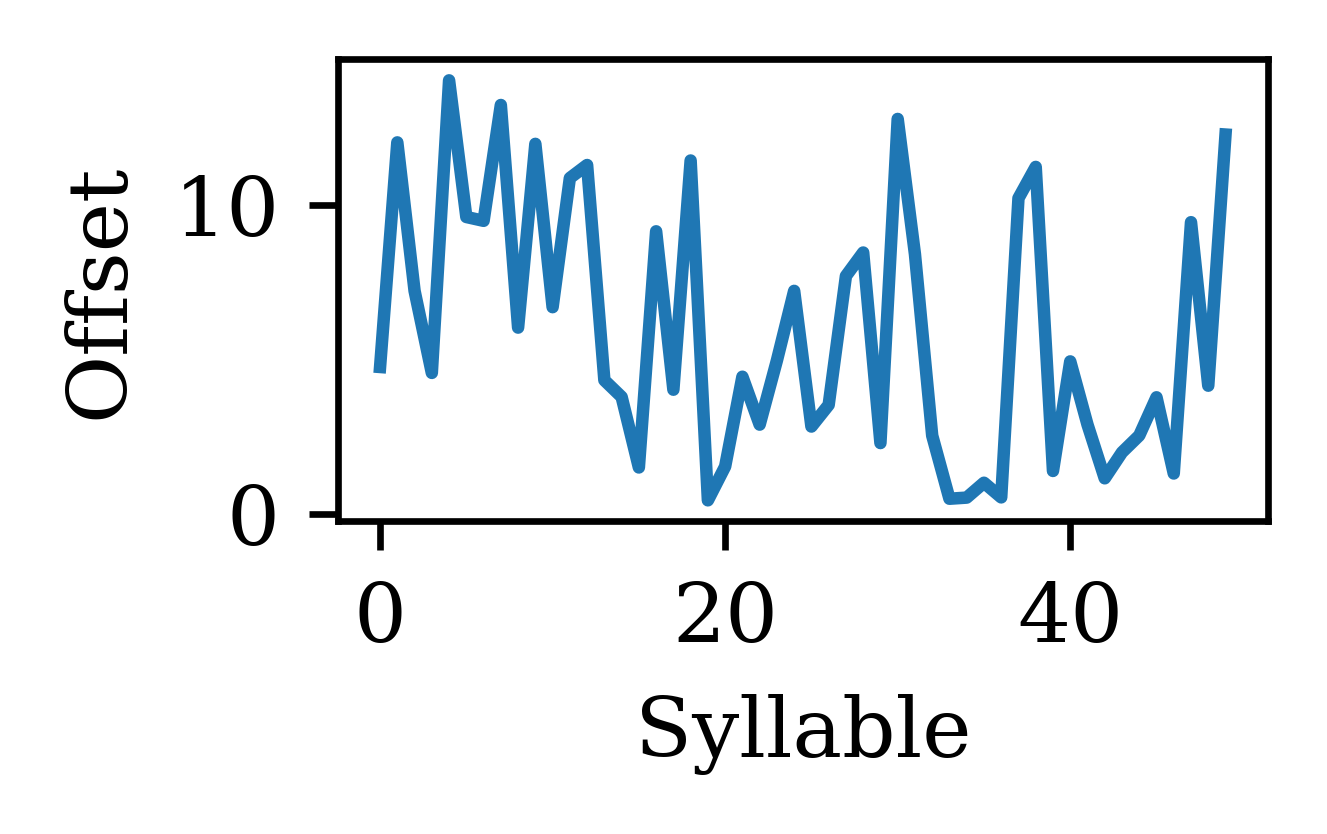

In [75]:
fig = figure(2, 1)
ax = fig.gca()
ax.plot(optimized_params['basis_weights'][:, 0])
ax.set(xlabel='Syllable', ylabel='Offset')

Text(0, 0.5, 'Syllables')

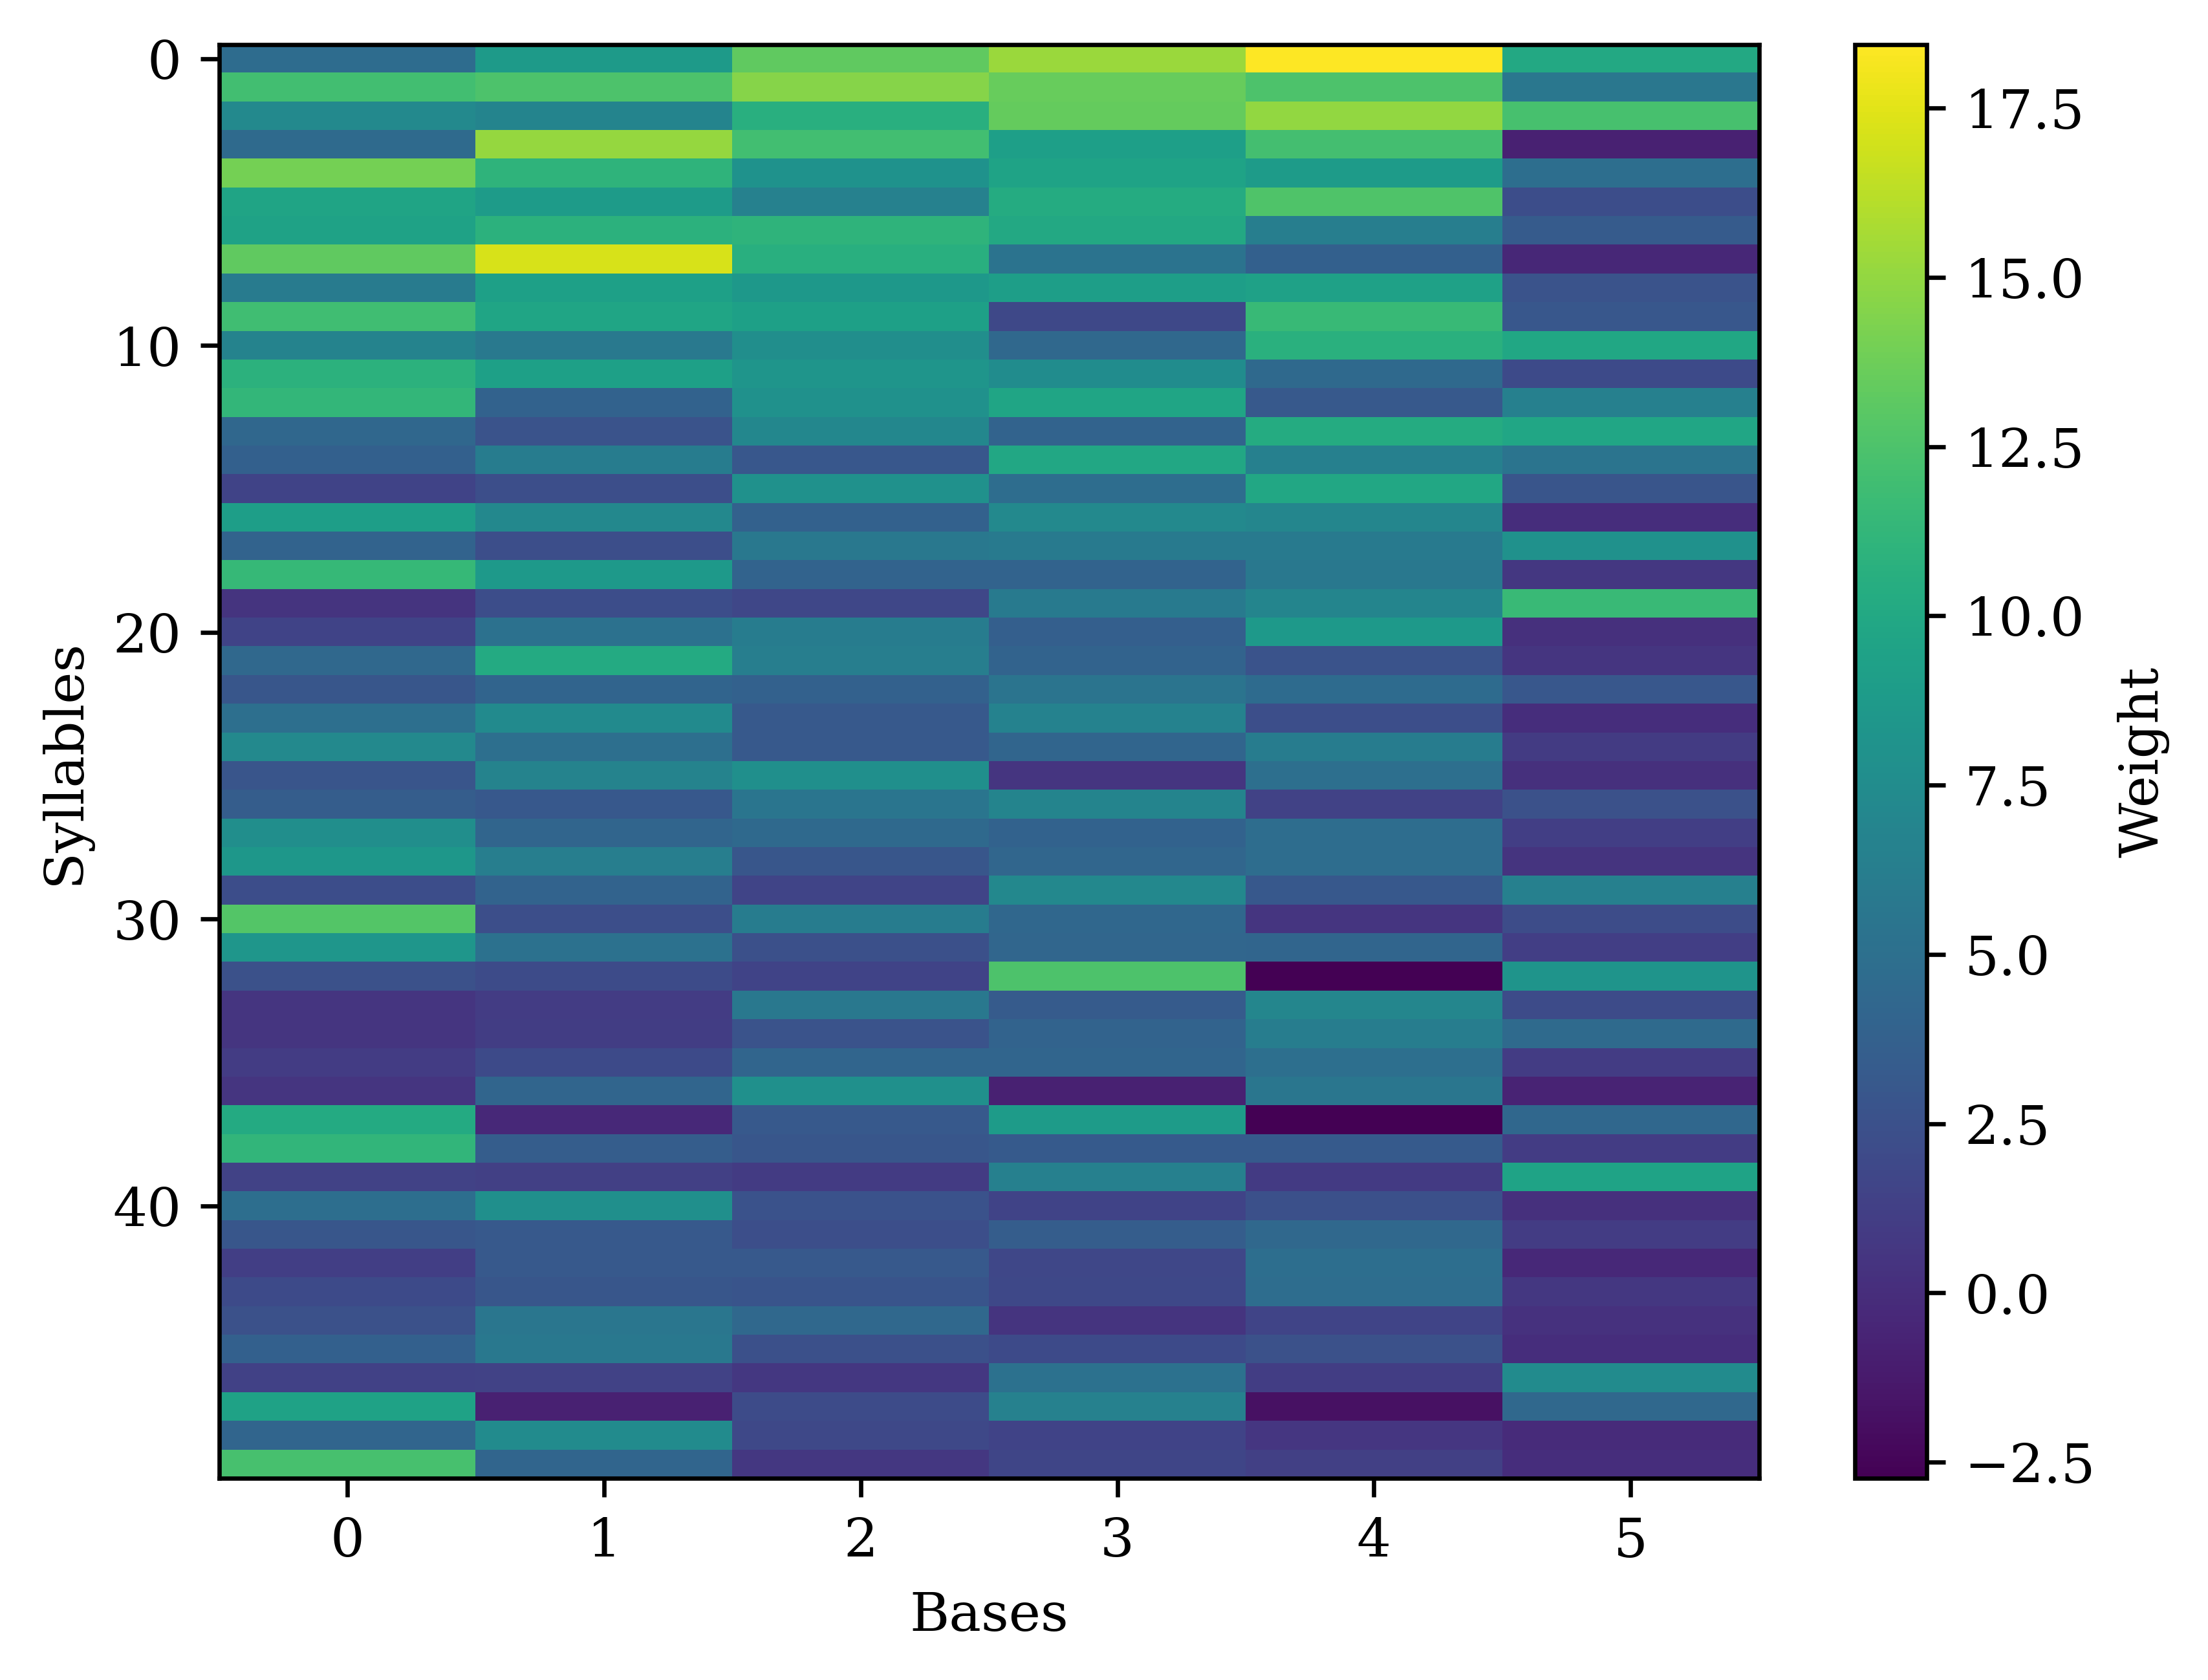

In [76]:
plt.imshow(optimized_params['basis_weights'], aspect='auto')
plt.colorbar(label="Weight")
plt.xlabel("Bases")
plt.ylabel("Syllables")

Text(0.5, 0, 'Iteration')

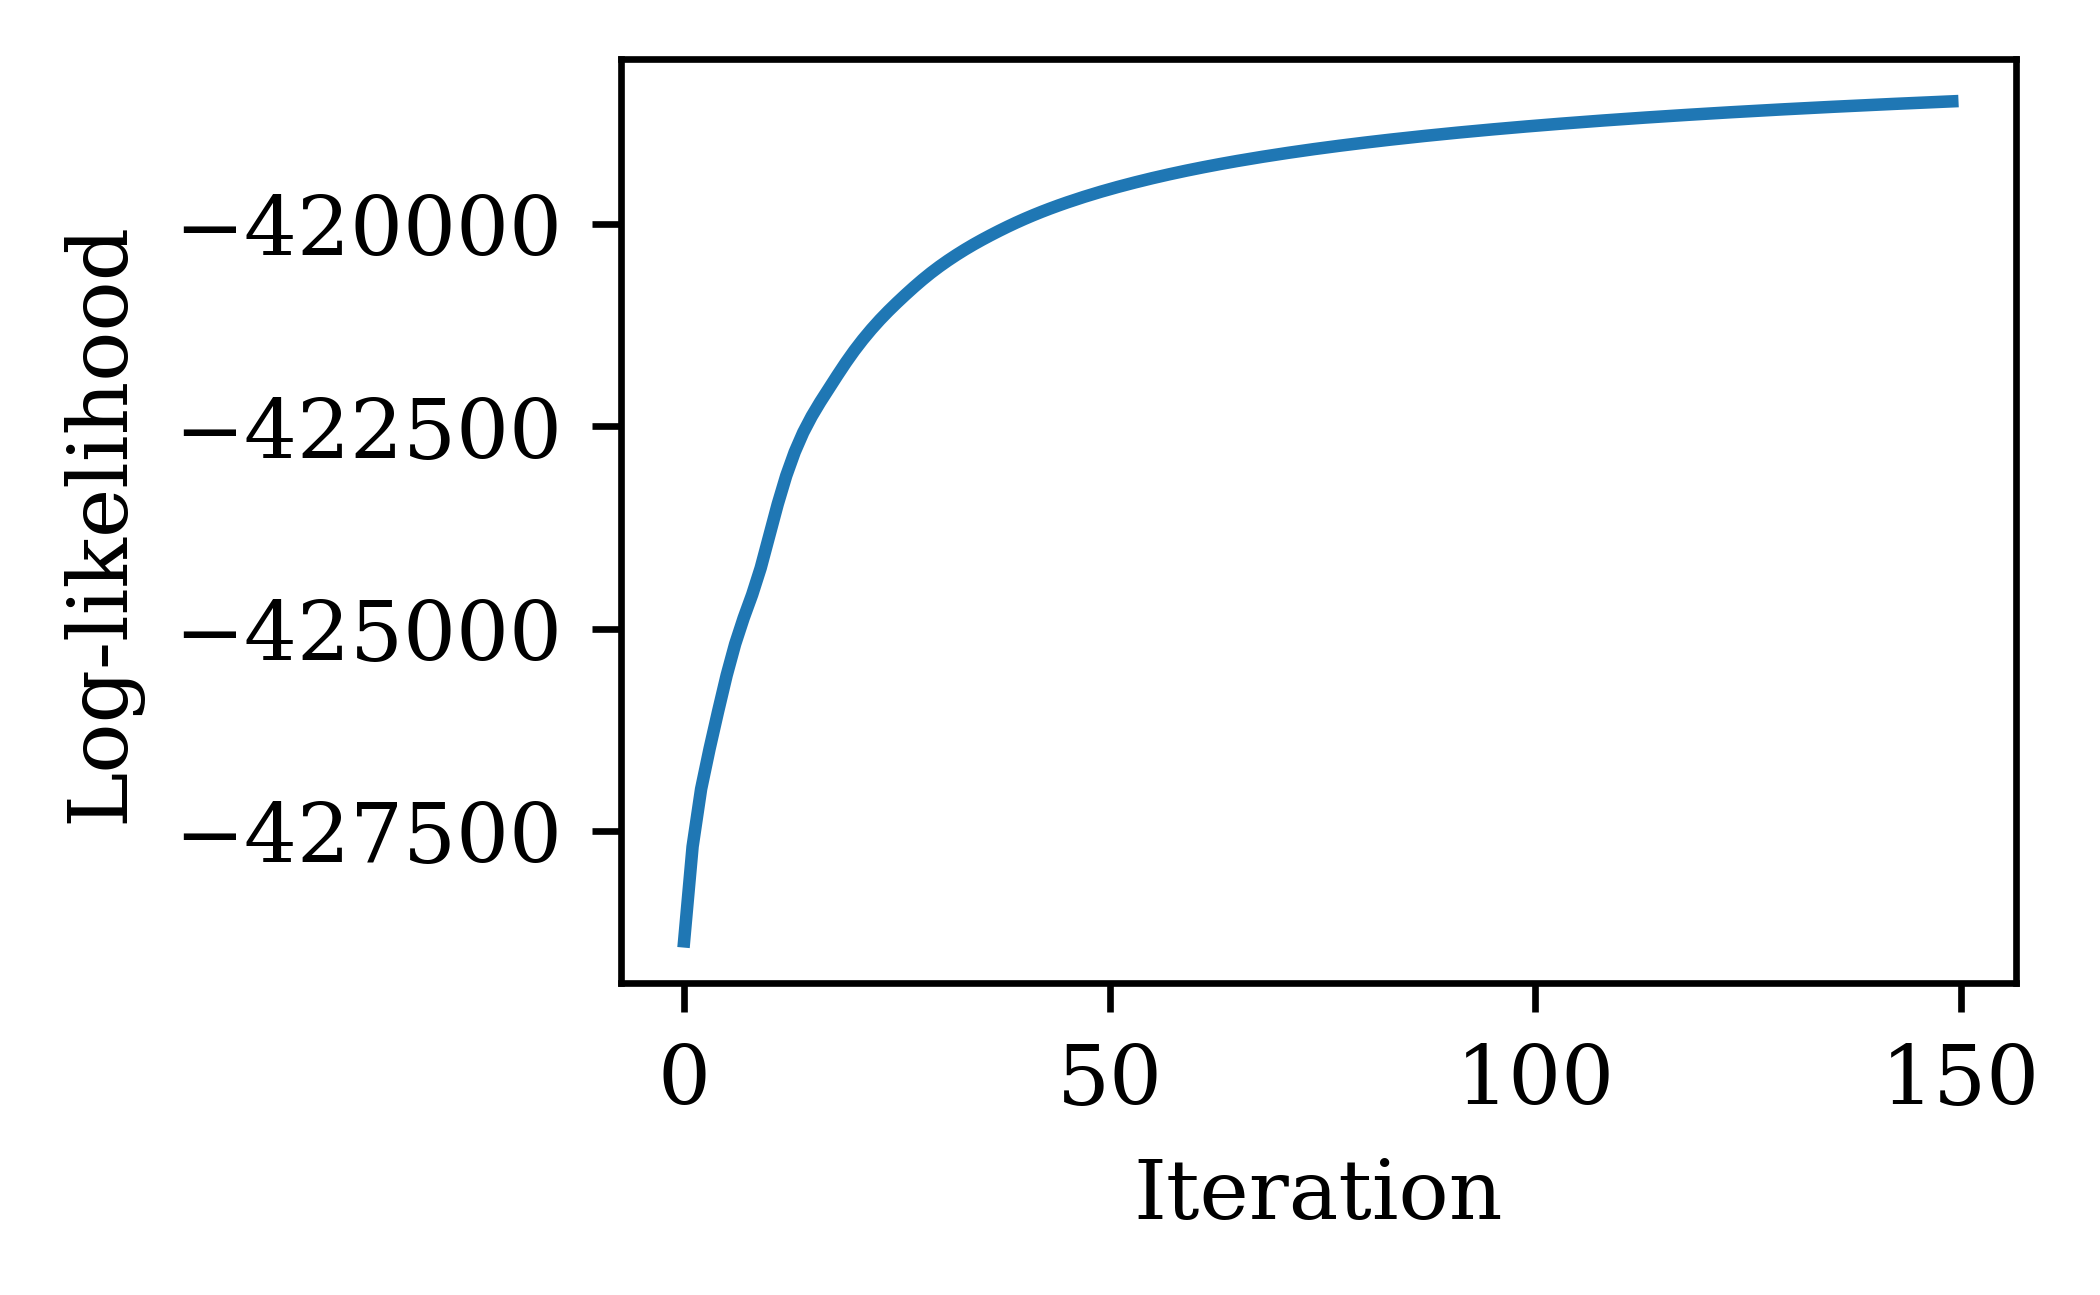

In [77]:
figure(3, 2)
plt.plot(-loss)
plt.ylabel("Log-likelihood")
plt.xlabel("Iteration")

In [78]:
# results = jnp.exp(jax.vmap(biological_age_fun, in_axes=(0, None, None))(jnp.log(jnp.linspace(3, 103, 50)), optimized_params['basis_weights'], basis_sd))
results = vectorized_biological_age(basis_values, optimized_params['basis_weights'])

Text(0.5, 0, 'Age (weeks)')

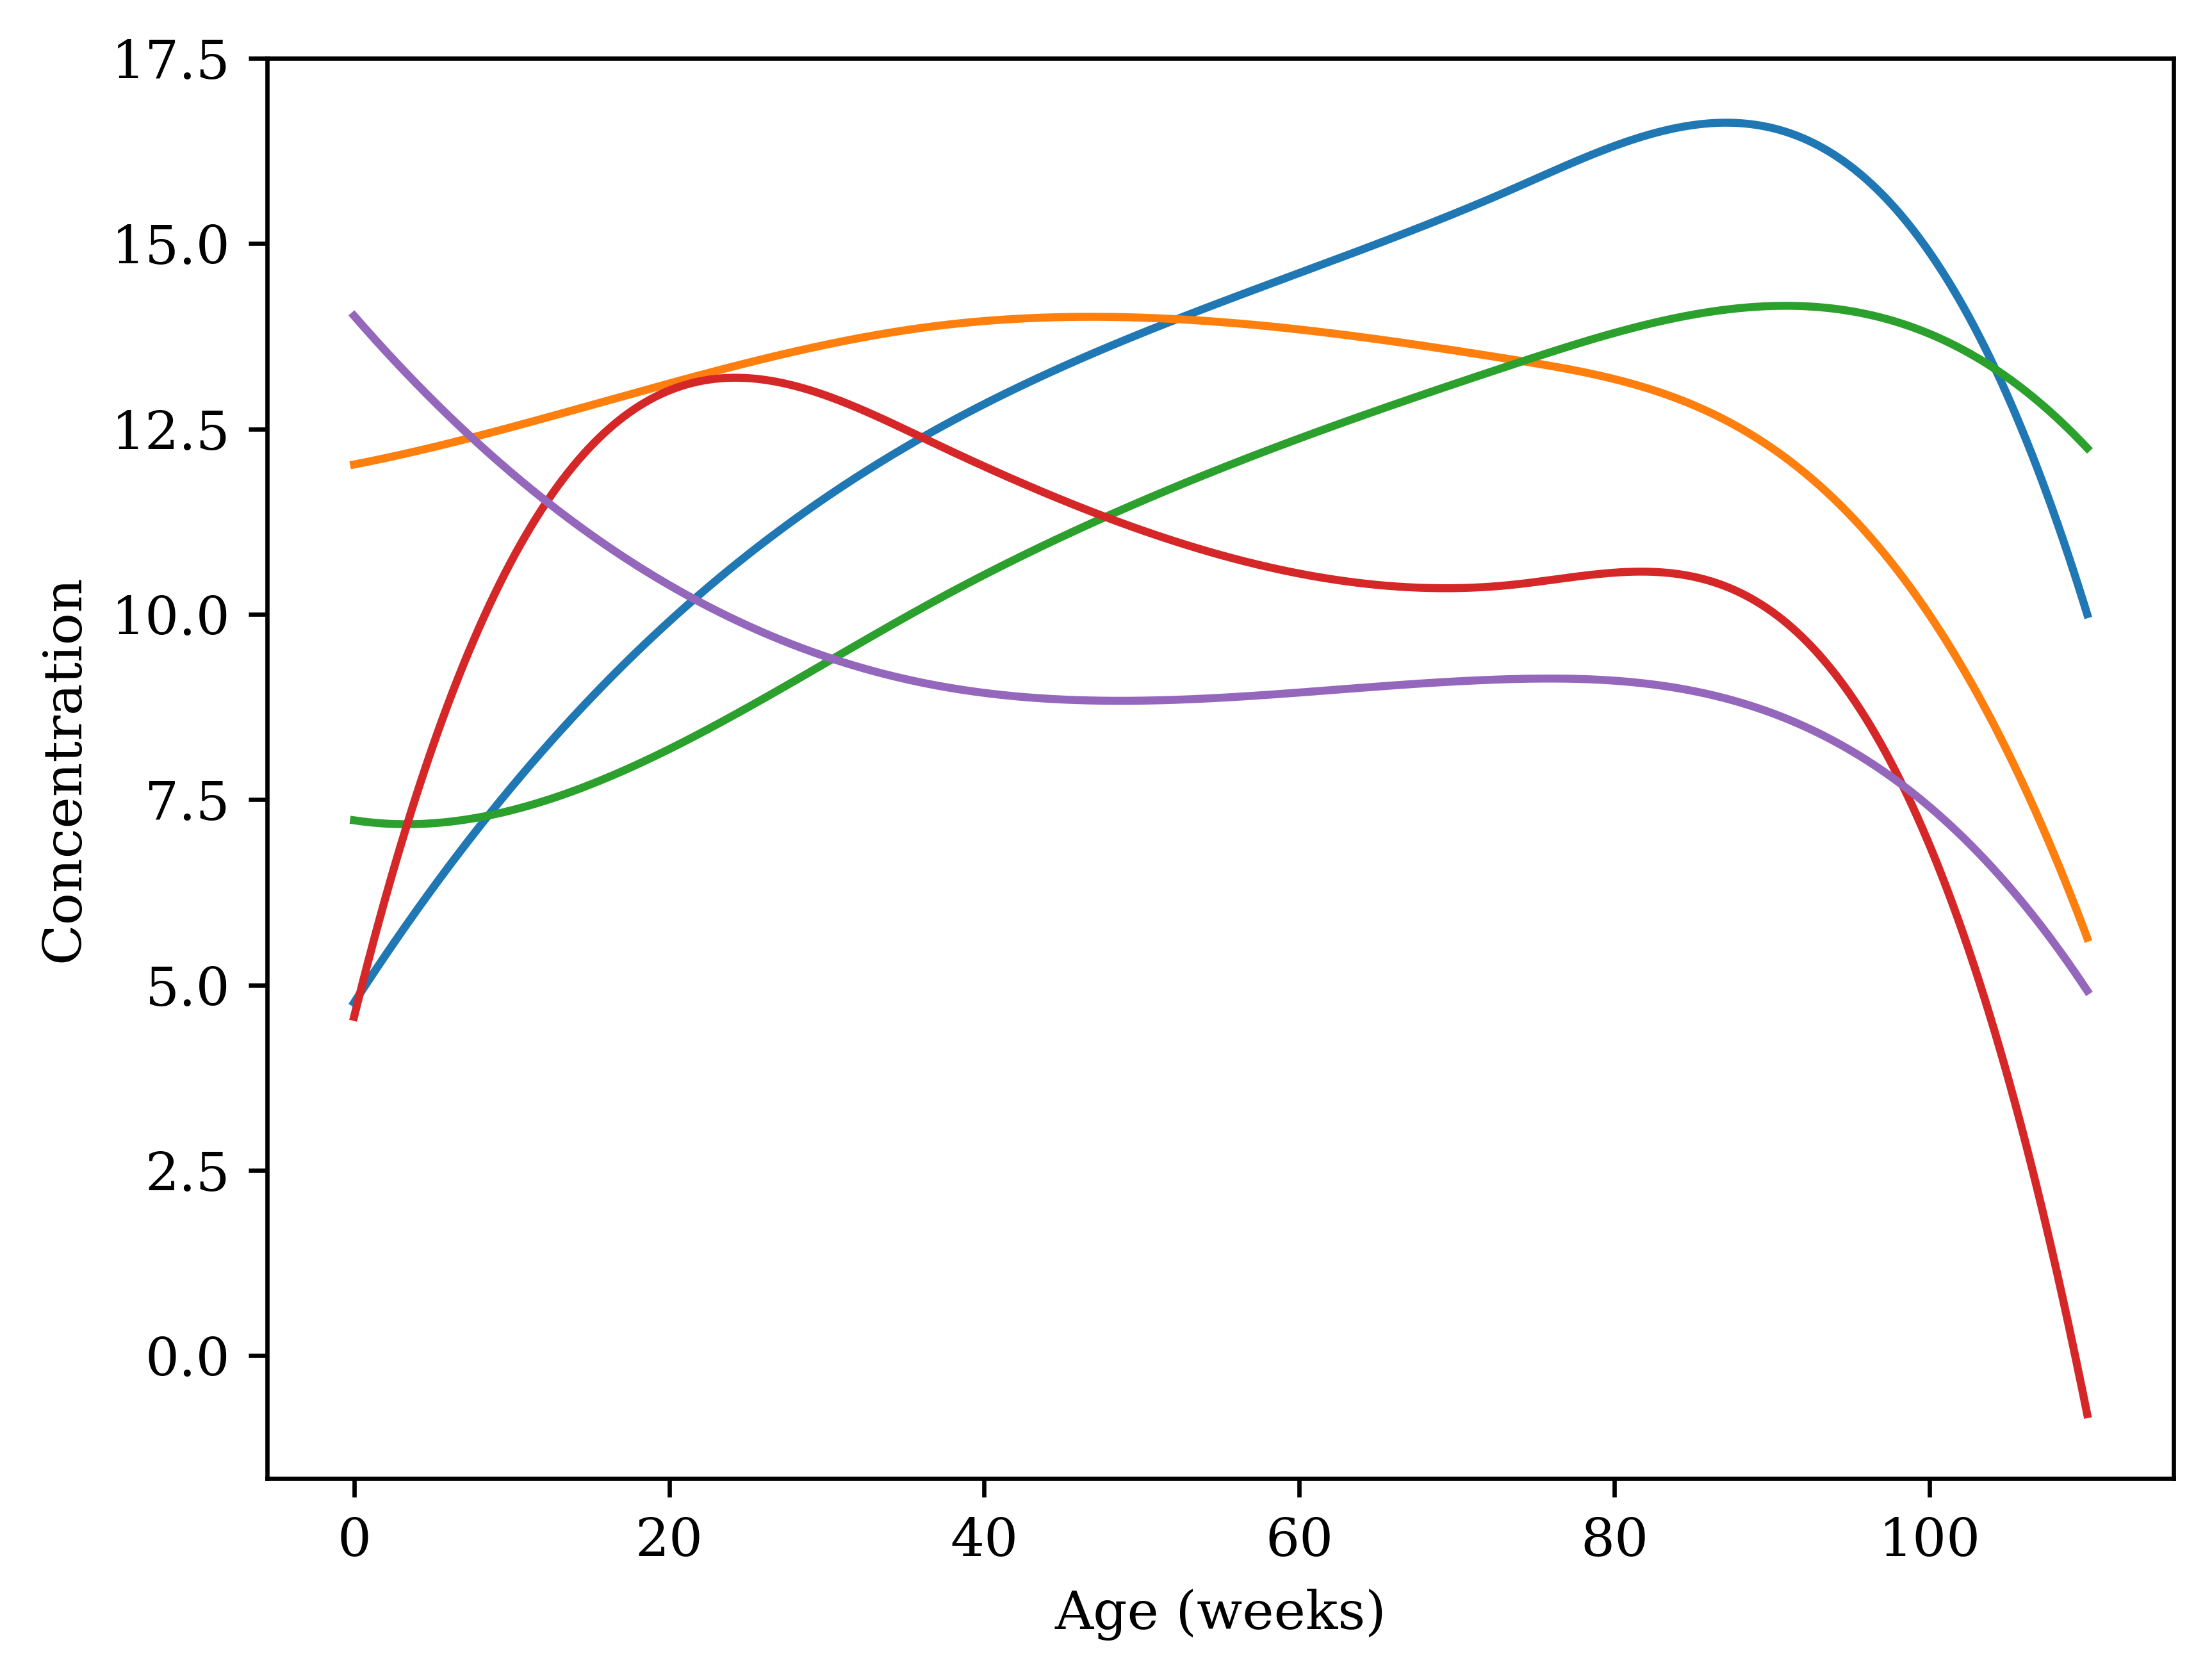

In [79]:
# for original model, it's results[:, :5]
plt.plot(jnp.linspace(0, 110, 1000), results[:5].T)
plt.ylabel("Concentration")
plt.xlabel("Age (weeks)")

[Text(0.5, 0, 'Age (weeks)'), Text(0, 0.5, 'Mean syllable count')]

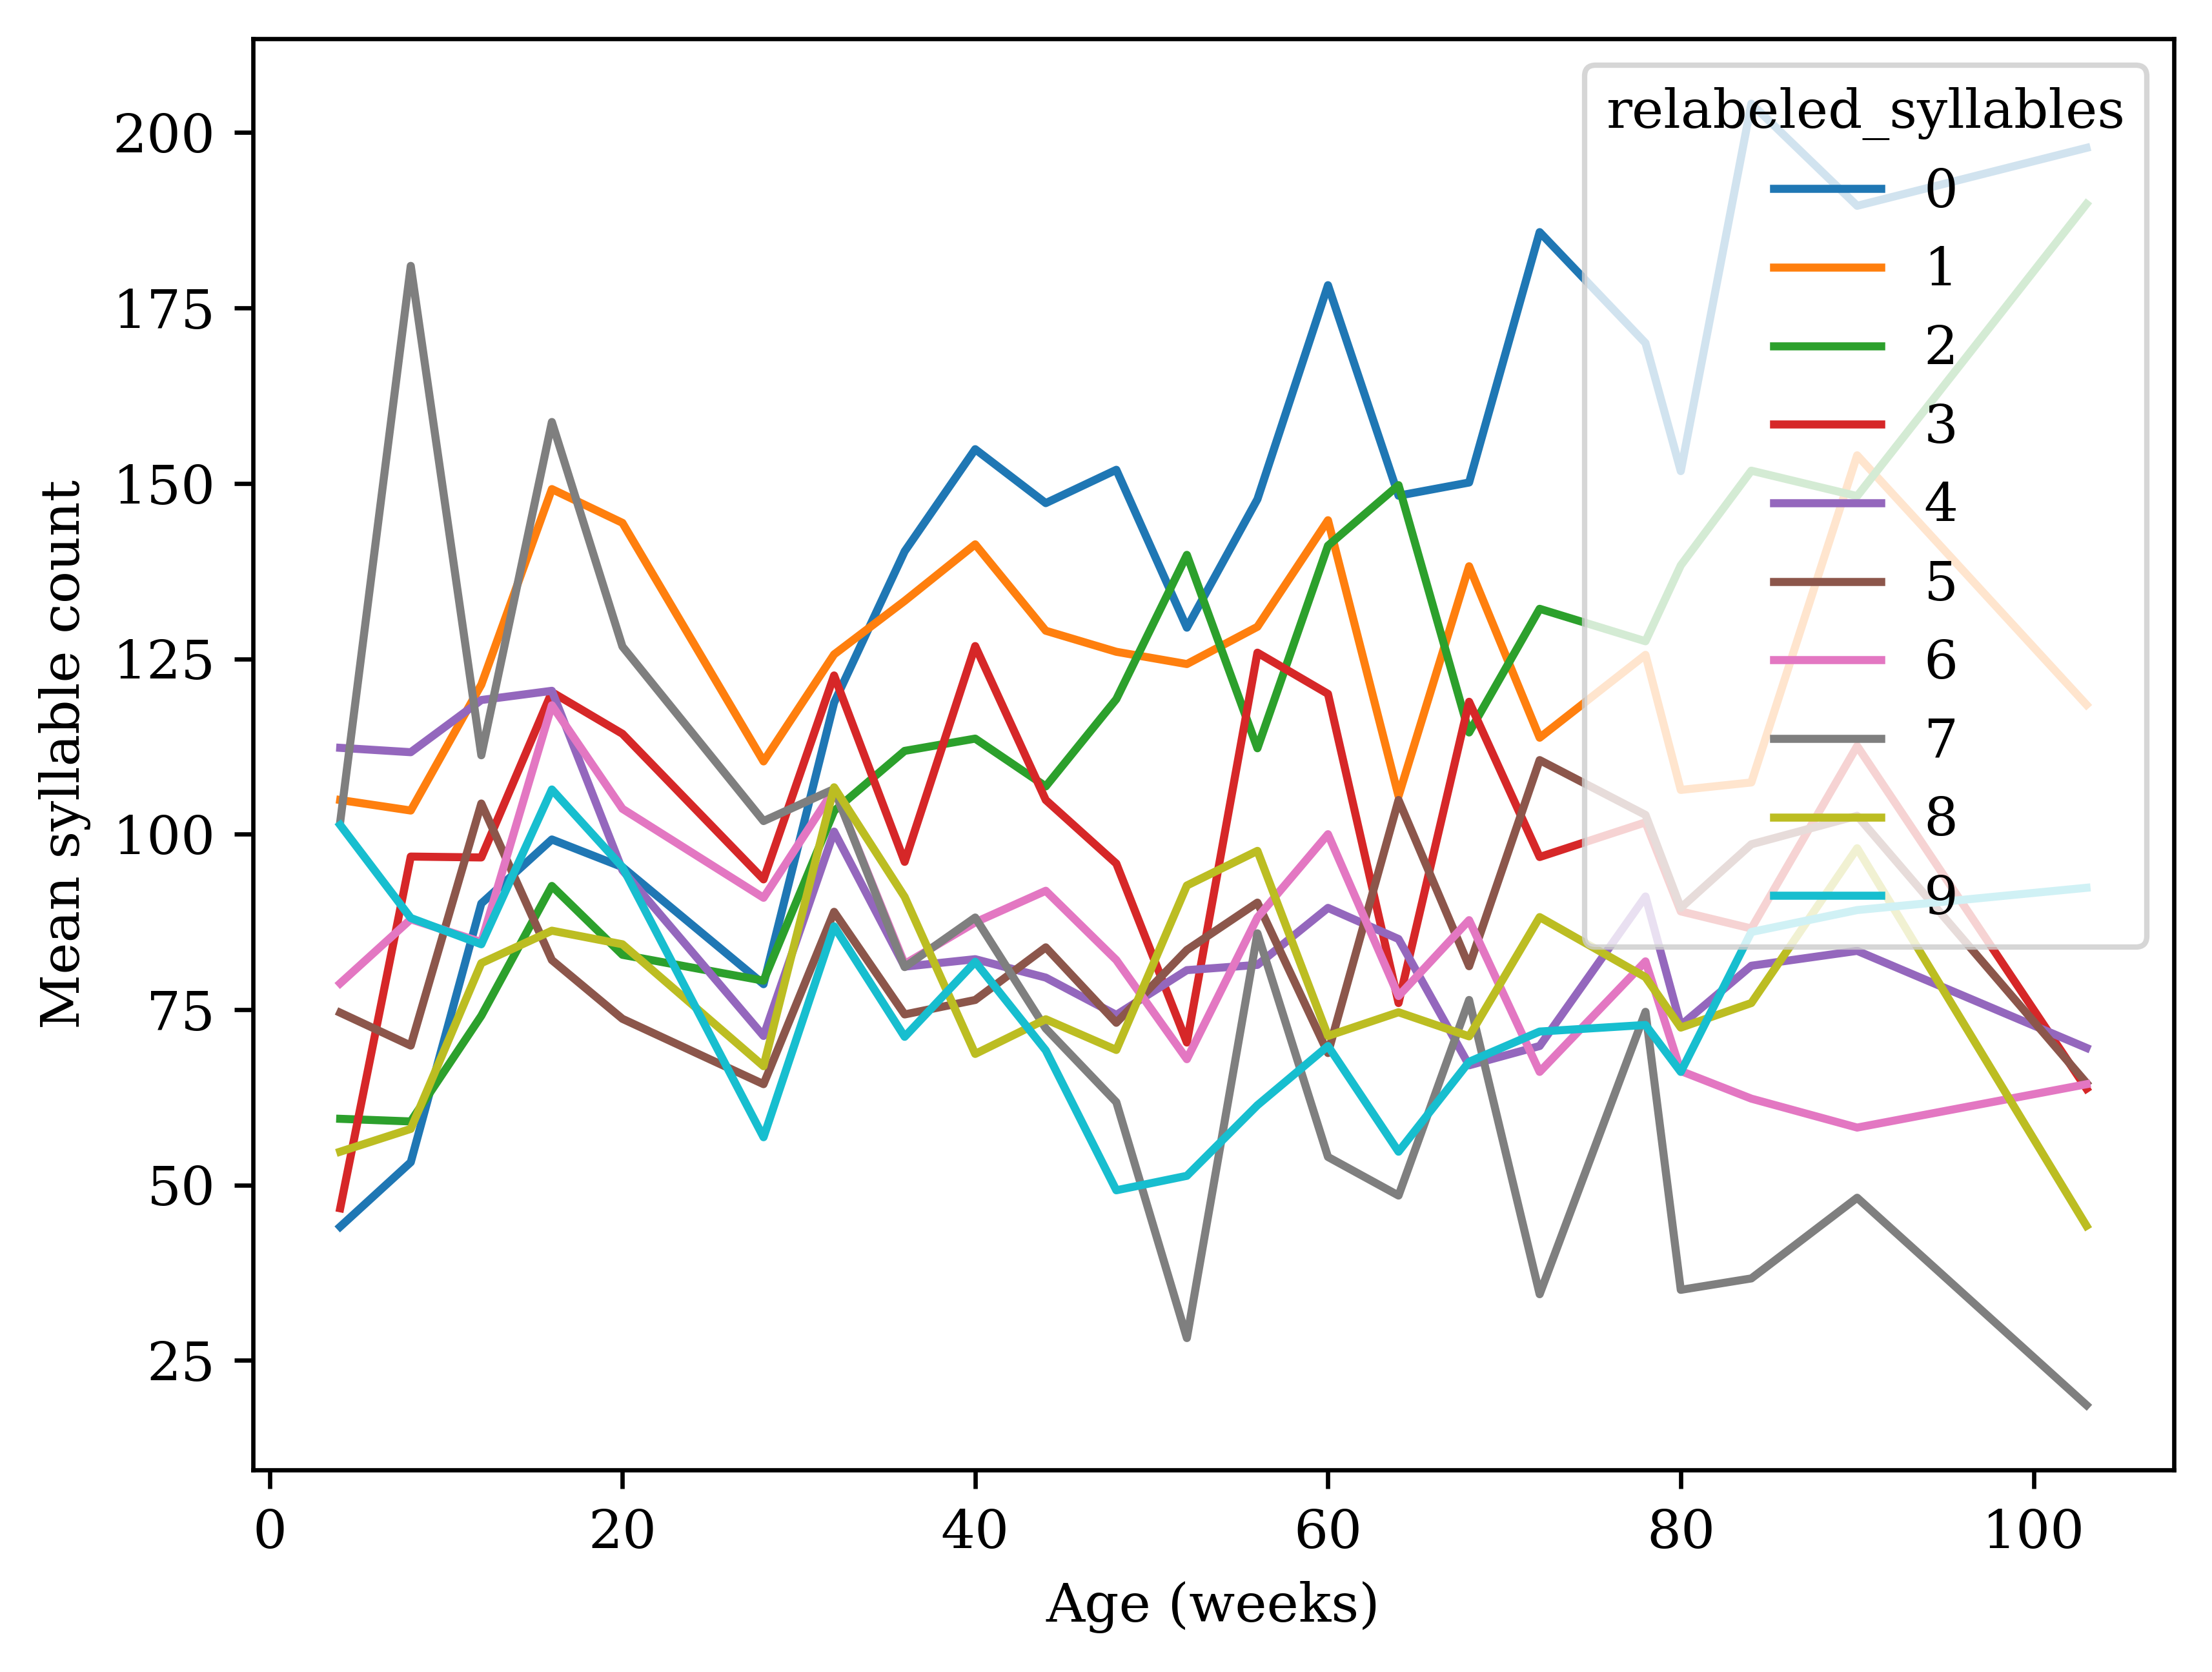

In [80]:
ax = syllable_counts.groupby('age').mean()[range(10)].plot()
ax.set(xlabel='Age (weeks)', ylabel='Mean syllable count')

In [81]:
age_x = jnp.linspace(0, 103, 500)
basis_values = BSplines(age_normalizer(age_x), df=6, degree=3, include_intercept=True).basis.T

In [82]:
log_probs = model_fun(optimized_params, basis_values, syllable_counts_jax)

In [83]:
log_probs.shape

(347, 500)

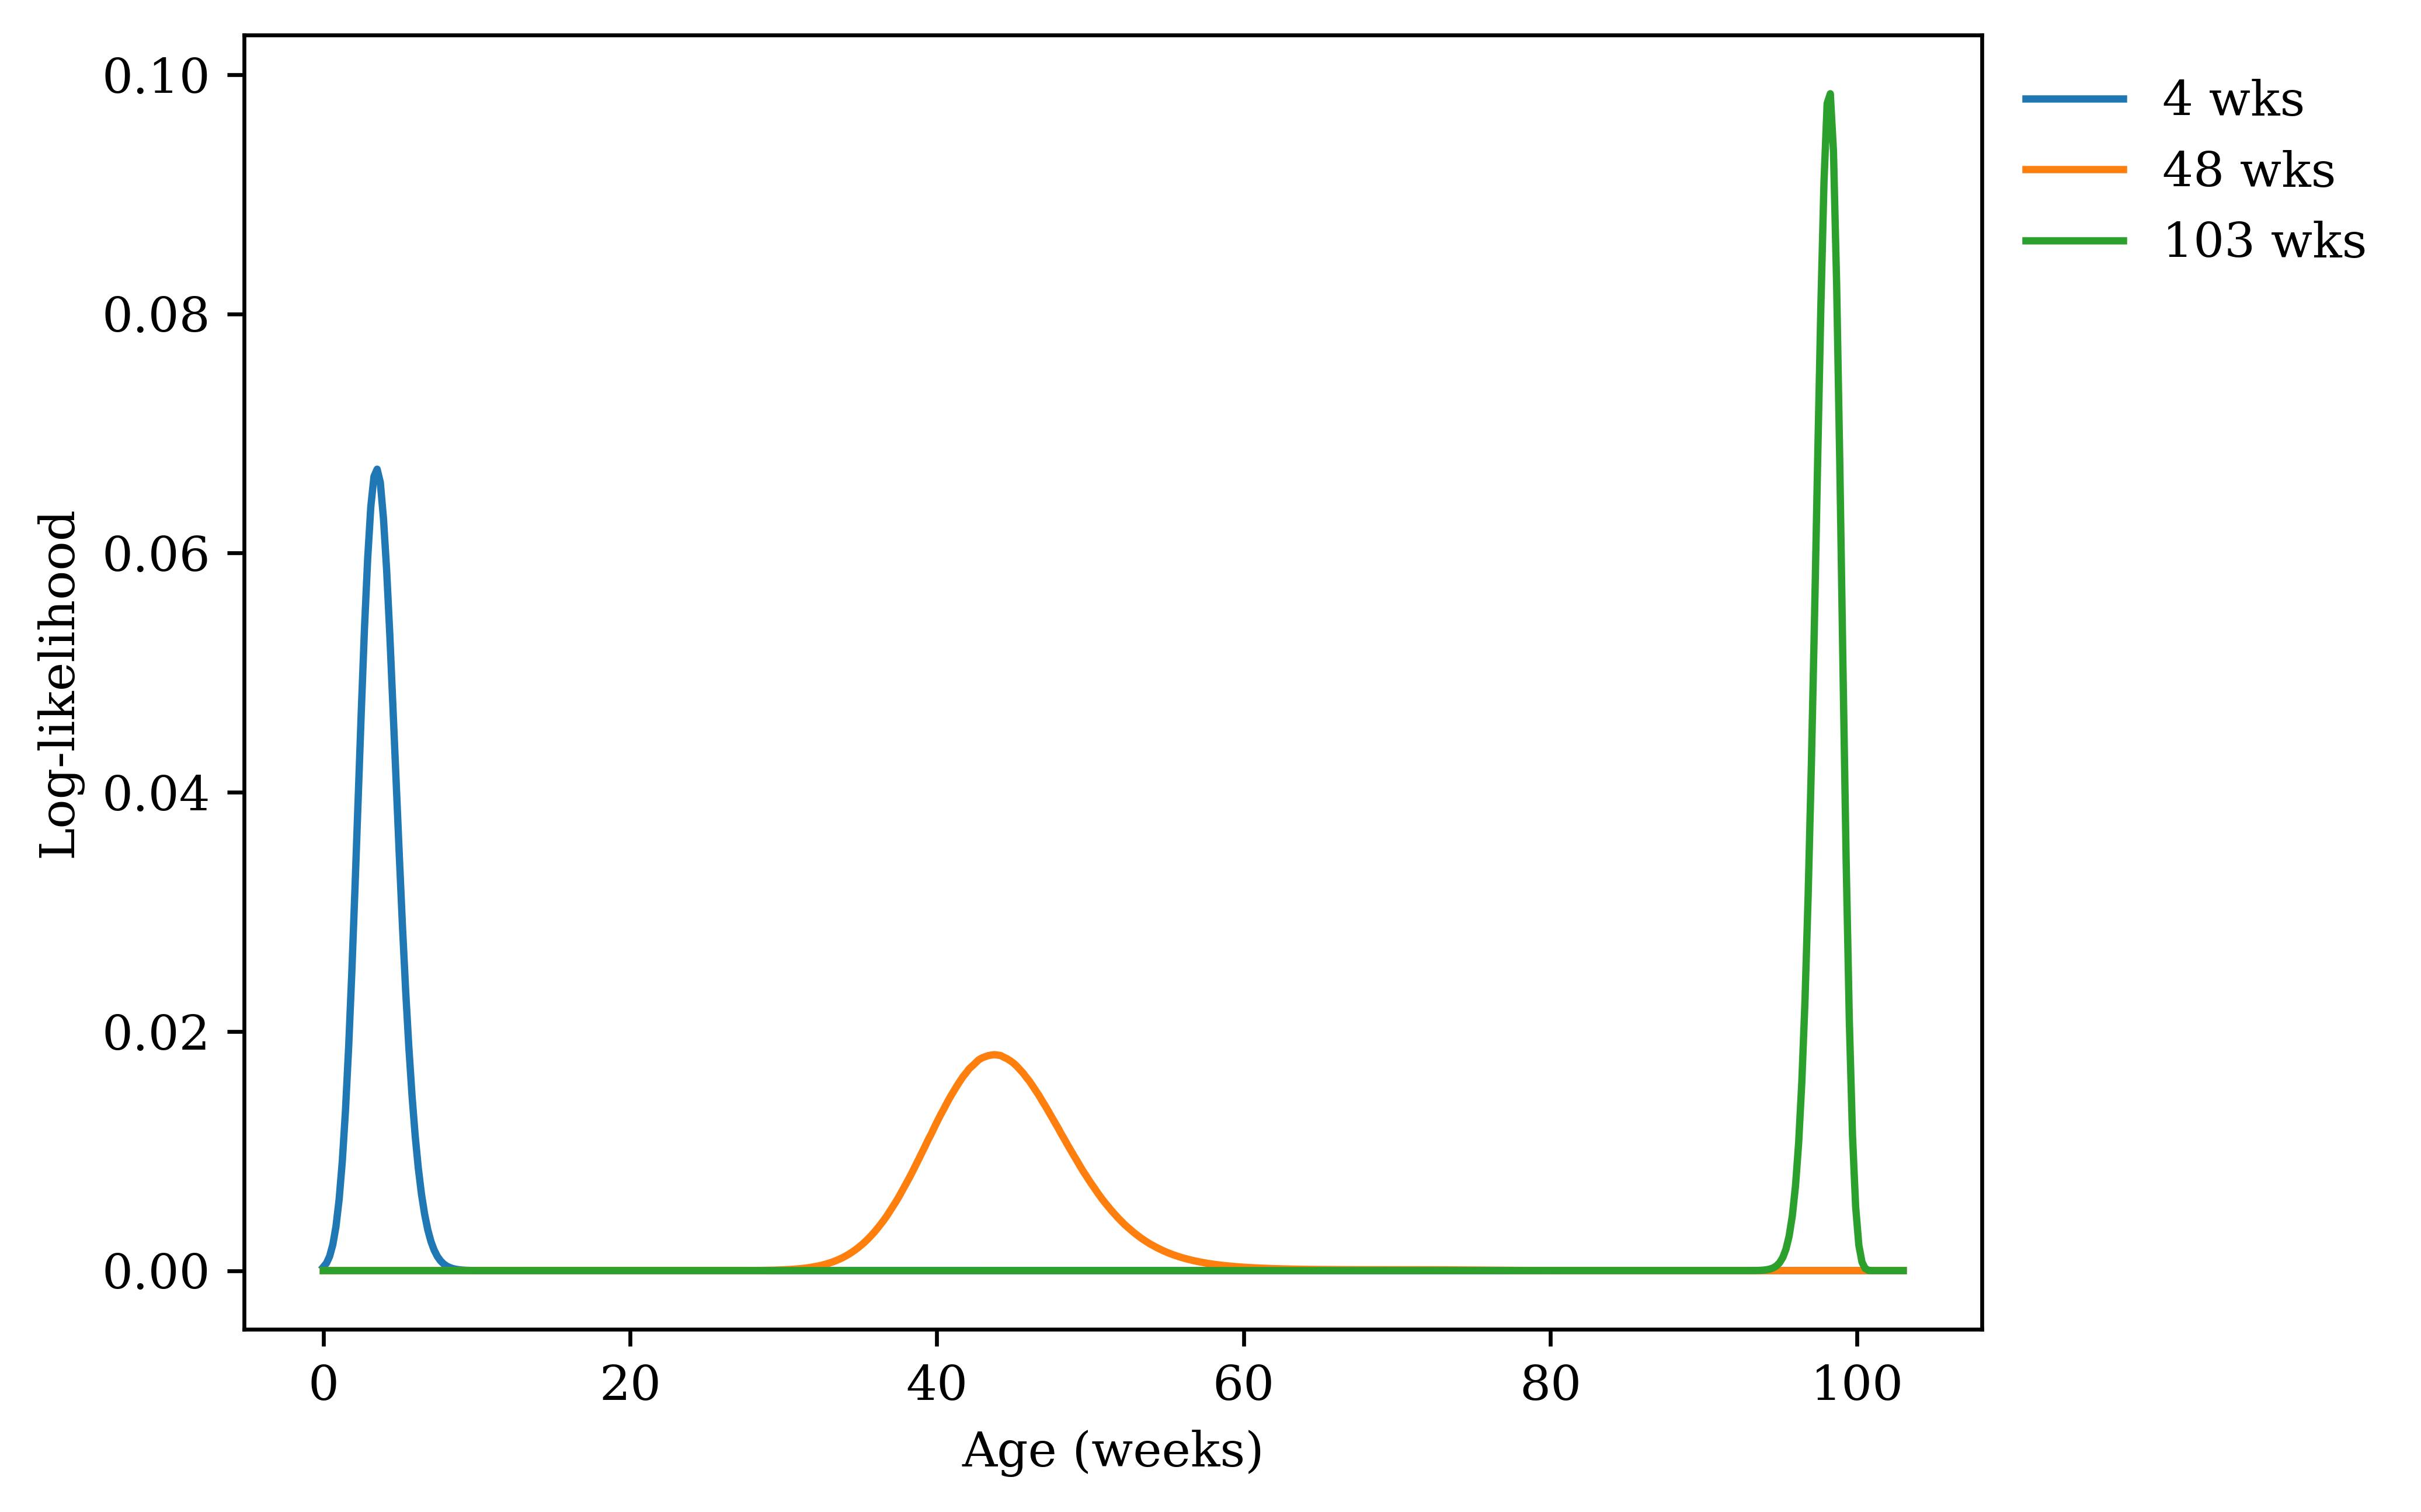

In [84]:
plt.plot(age_x, jax.nn.softmax(log_probs[:5].T.mean(1)), label="4 wks")
plt.plot(age_x, jax.nn.softmax(log_probs[160:165].T.mean(1)), label="48 wks")
plt.plot(age_x, jax.nn.softmax(log_probs[-5:].T.mean(1)), label="103 wks")
plt.xlabel("Age (weeks)")
plt.ylabel("Log-likelihood")
legend()

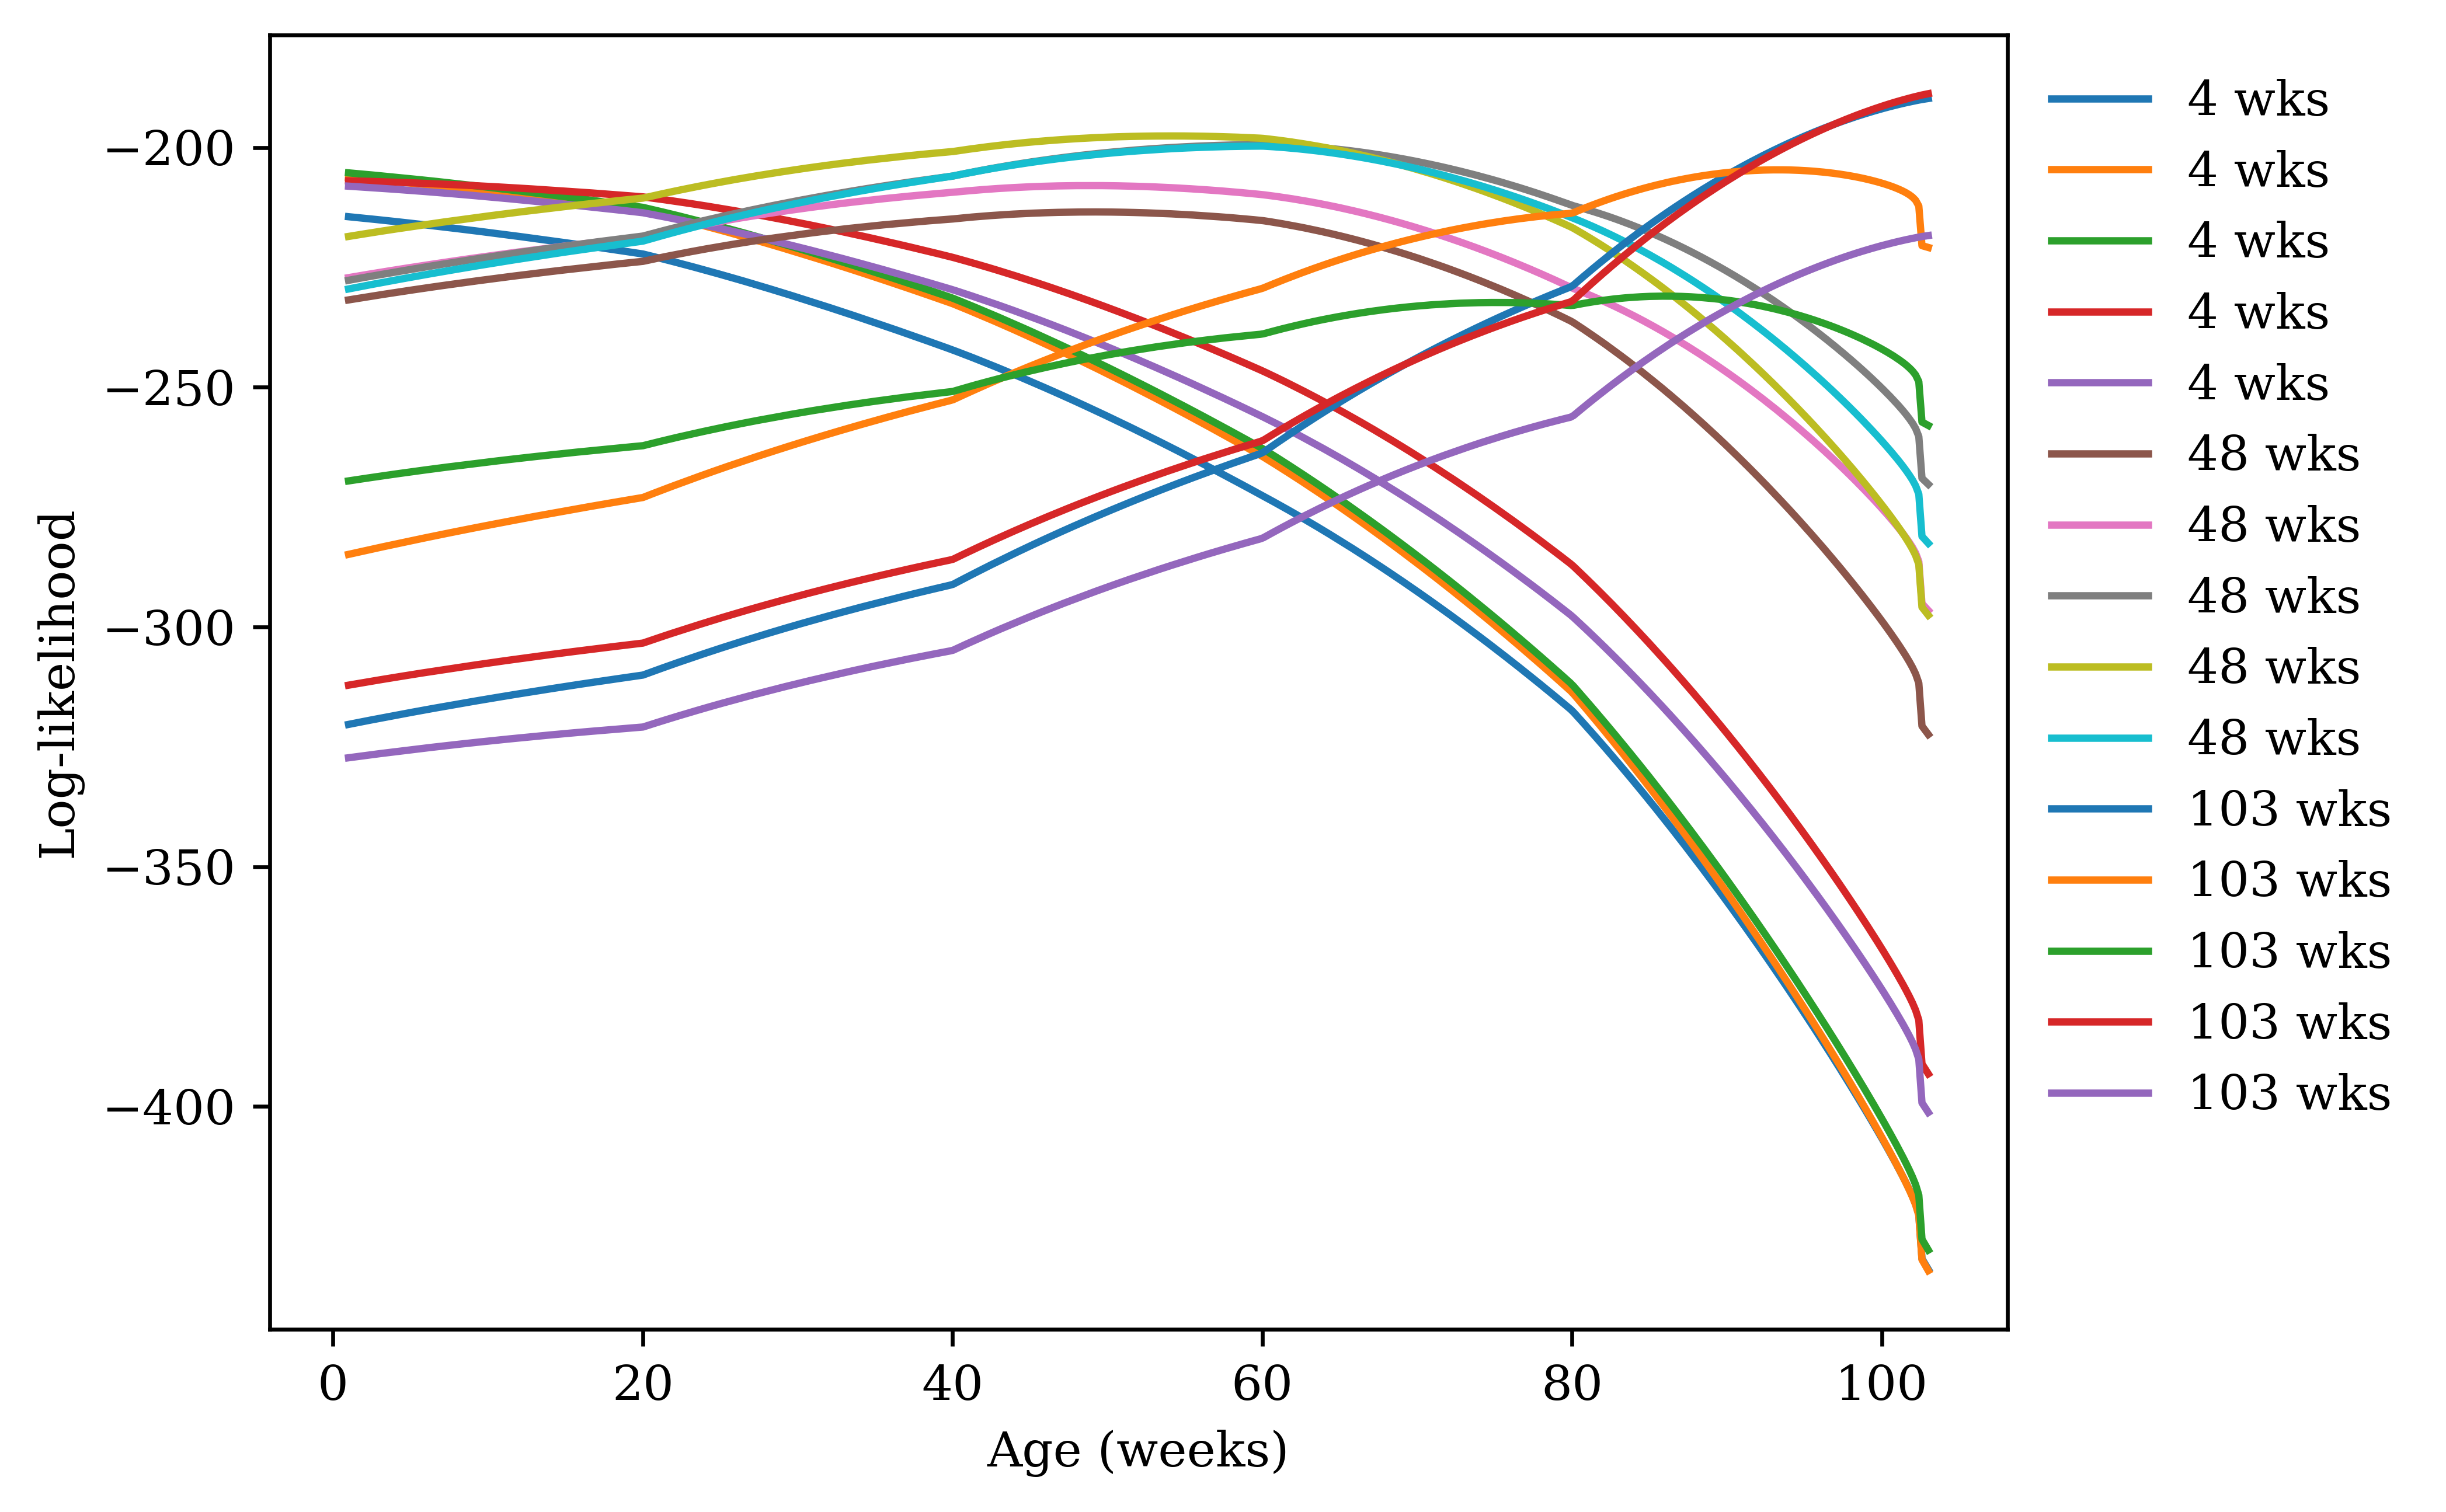

In [50]:
plt.plot(age_x, log_probs[:5].T, label="4 wks")
plt.plot(age_x, log_probs[160:165].T, label="48 wks")
plt.plot(age_x, log_probs[-5:].T, label="103 wks")
plt.xlabel("Age (weeks)")
plt.ylabel("Log-likelihood")
legend()

## Pseudo-counts vs likelihood distribution shapes

In [98]:
usage_frequencies = (syllable_counts_jax + 1) / (syllable_counts_jax + 1).sum(axis=1)[:, None]

In [107]:
from toolz import concatv

In [220]:
pseudocount_factor = np.logspace(0, np.log10(600), 7)

In [222]:
# shape = k bases, n_sessions
bs = BSplines(np.linspace(0, 1, 1000), df=6, degree=3, include_intercept=True)
A = bs.transform(age_normalizer(age)).T

factor_results = {}
for factor in pseudocount_factor:
    freqs = usage_frequencies * factor
    theta, *_ = np.linalg.lstsq(A.T, np.log(freqs), rcond=None)
    age_x = age_normalizer(jnp.linspace(0, 110, 500))
    basis_values = bs.transform(age_x).T
    log_probs = model_fun({'basis_weights': theta.T}, basis_values, age_x, age_normalizer(age), syllable_counts_jax)
    factor_results[factor] = log_probs

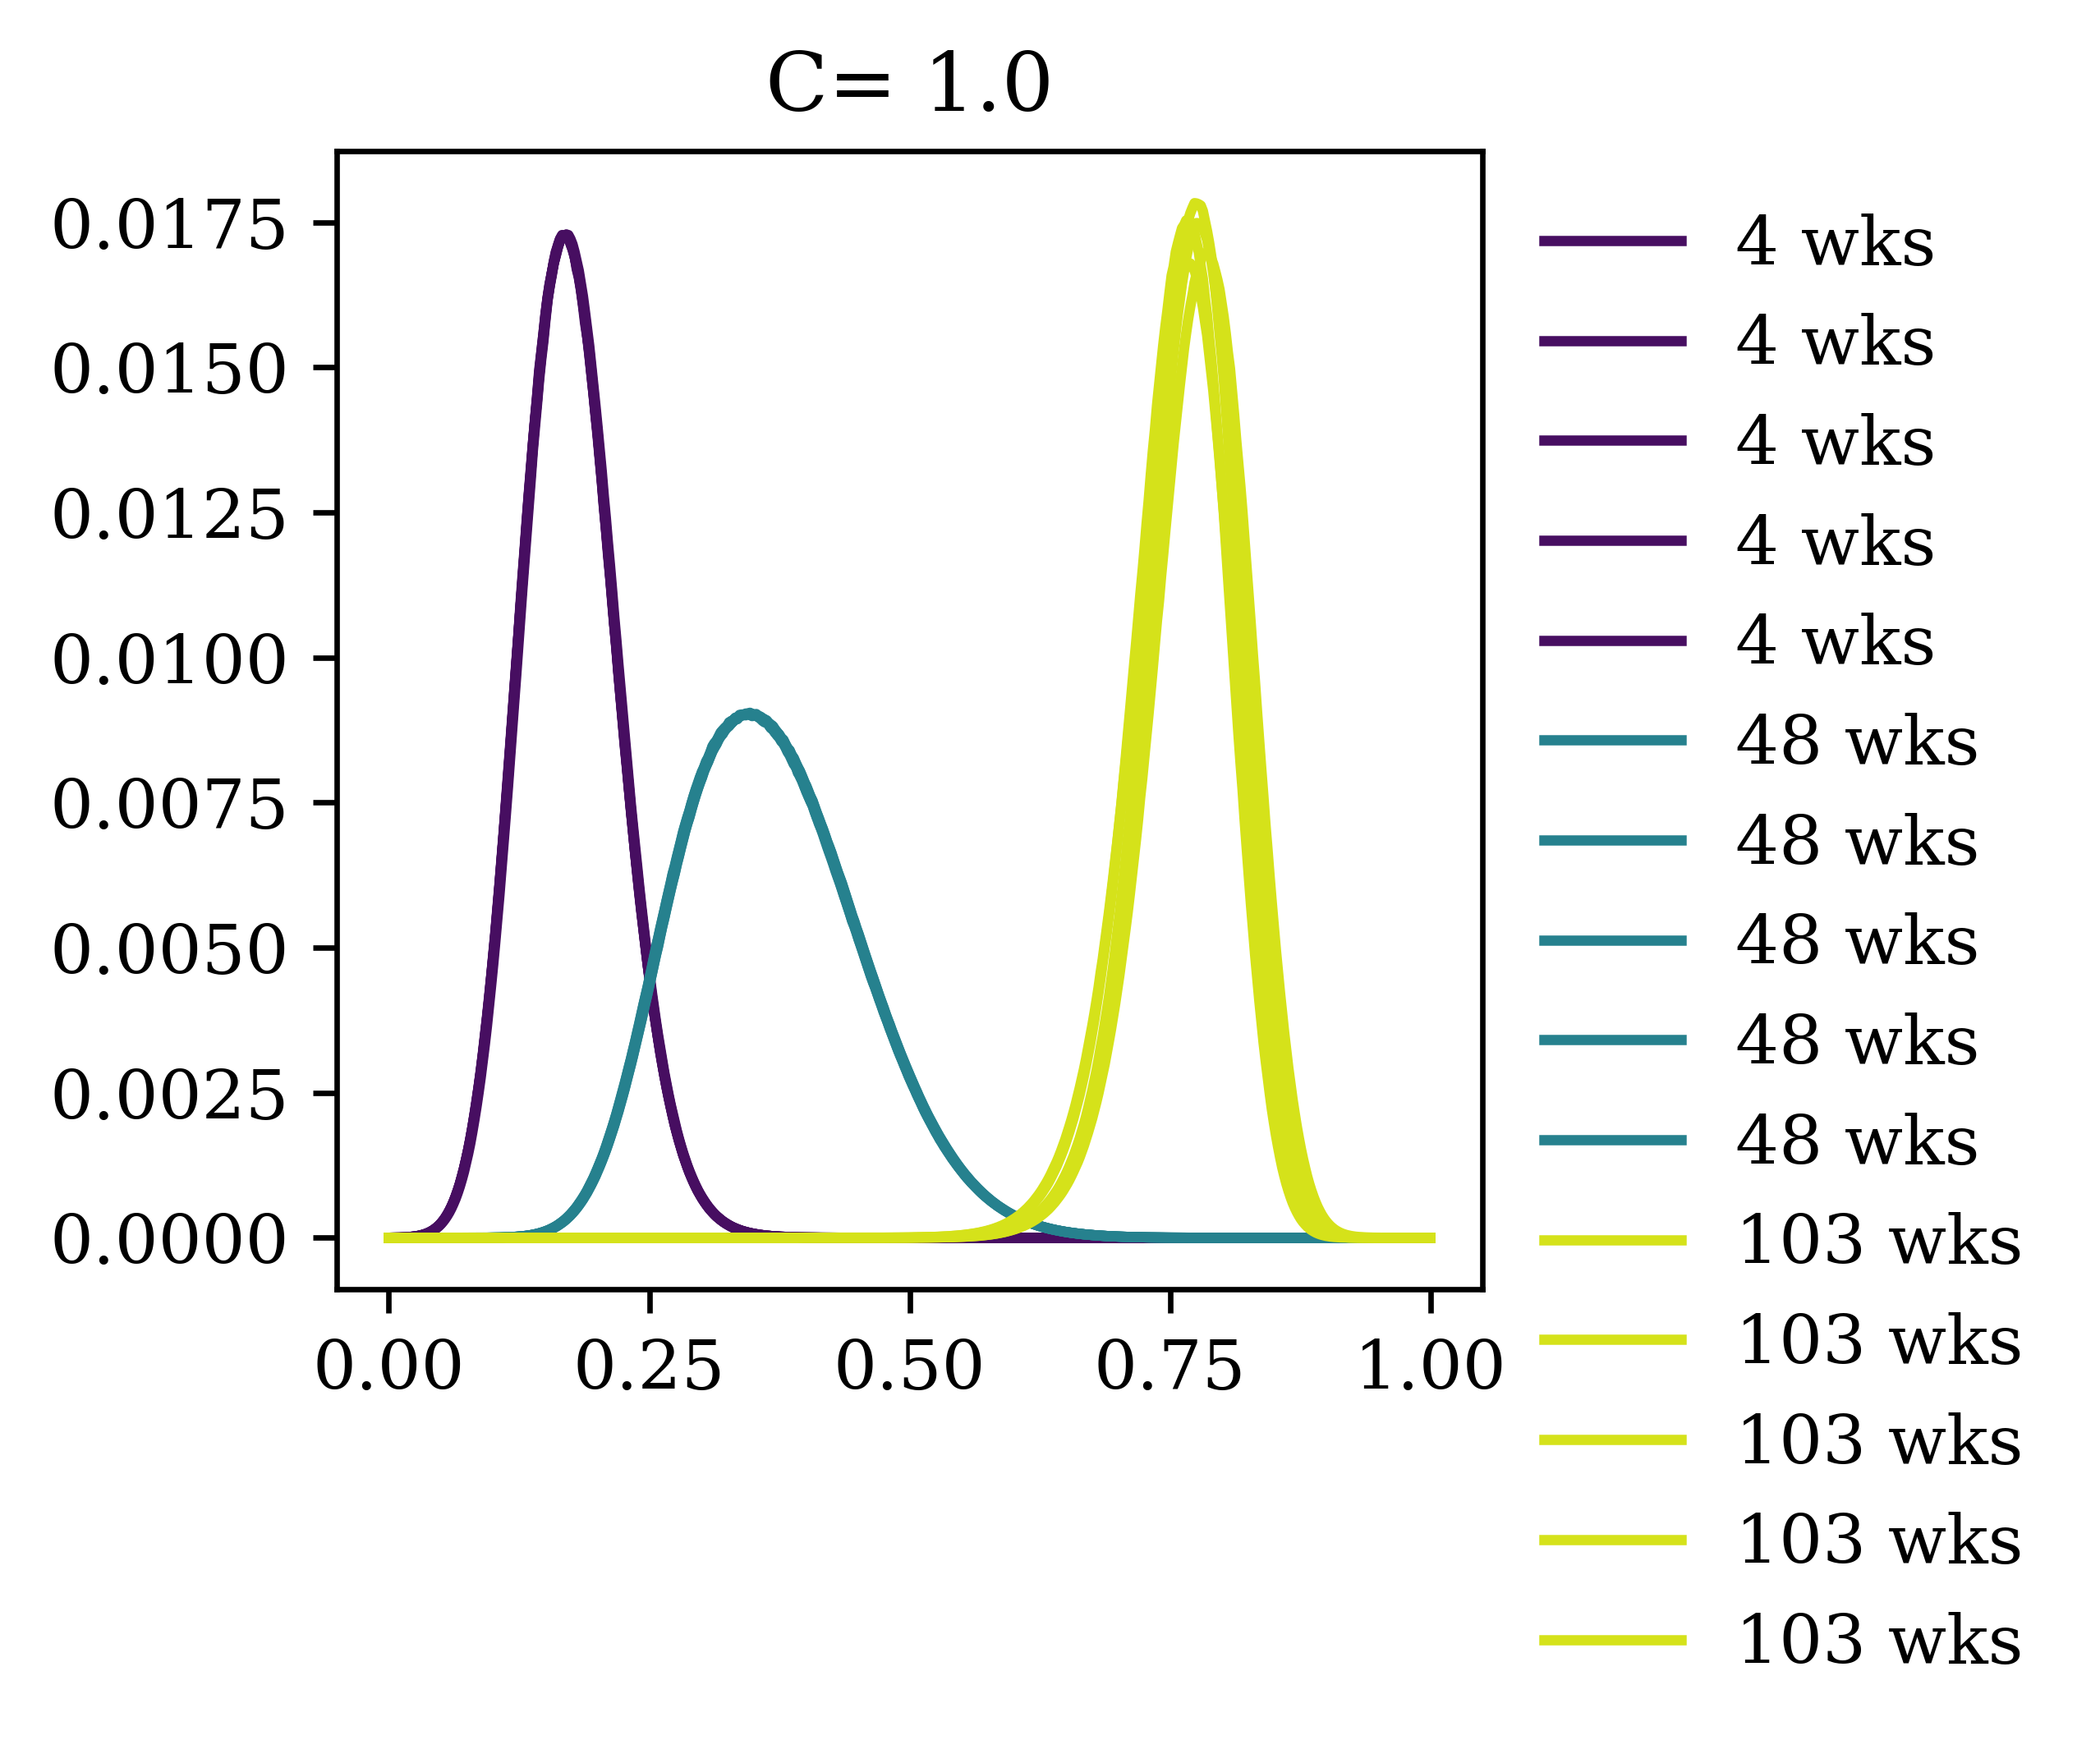

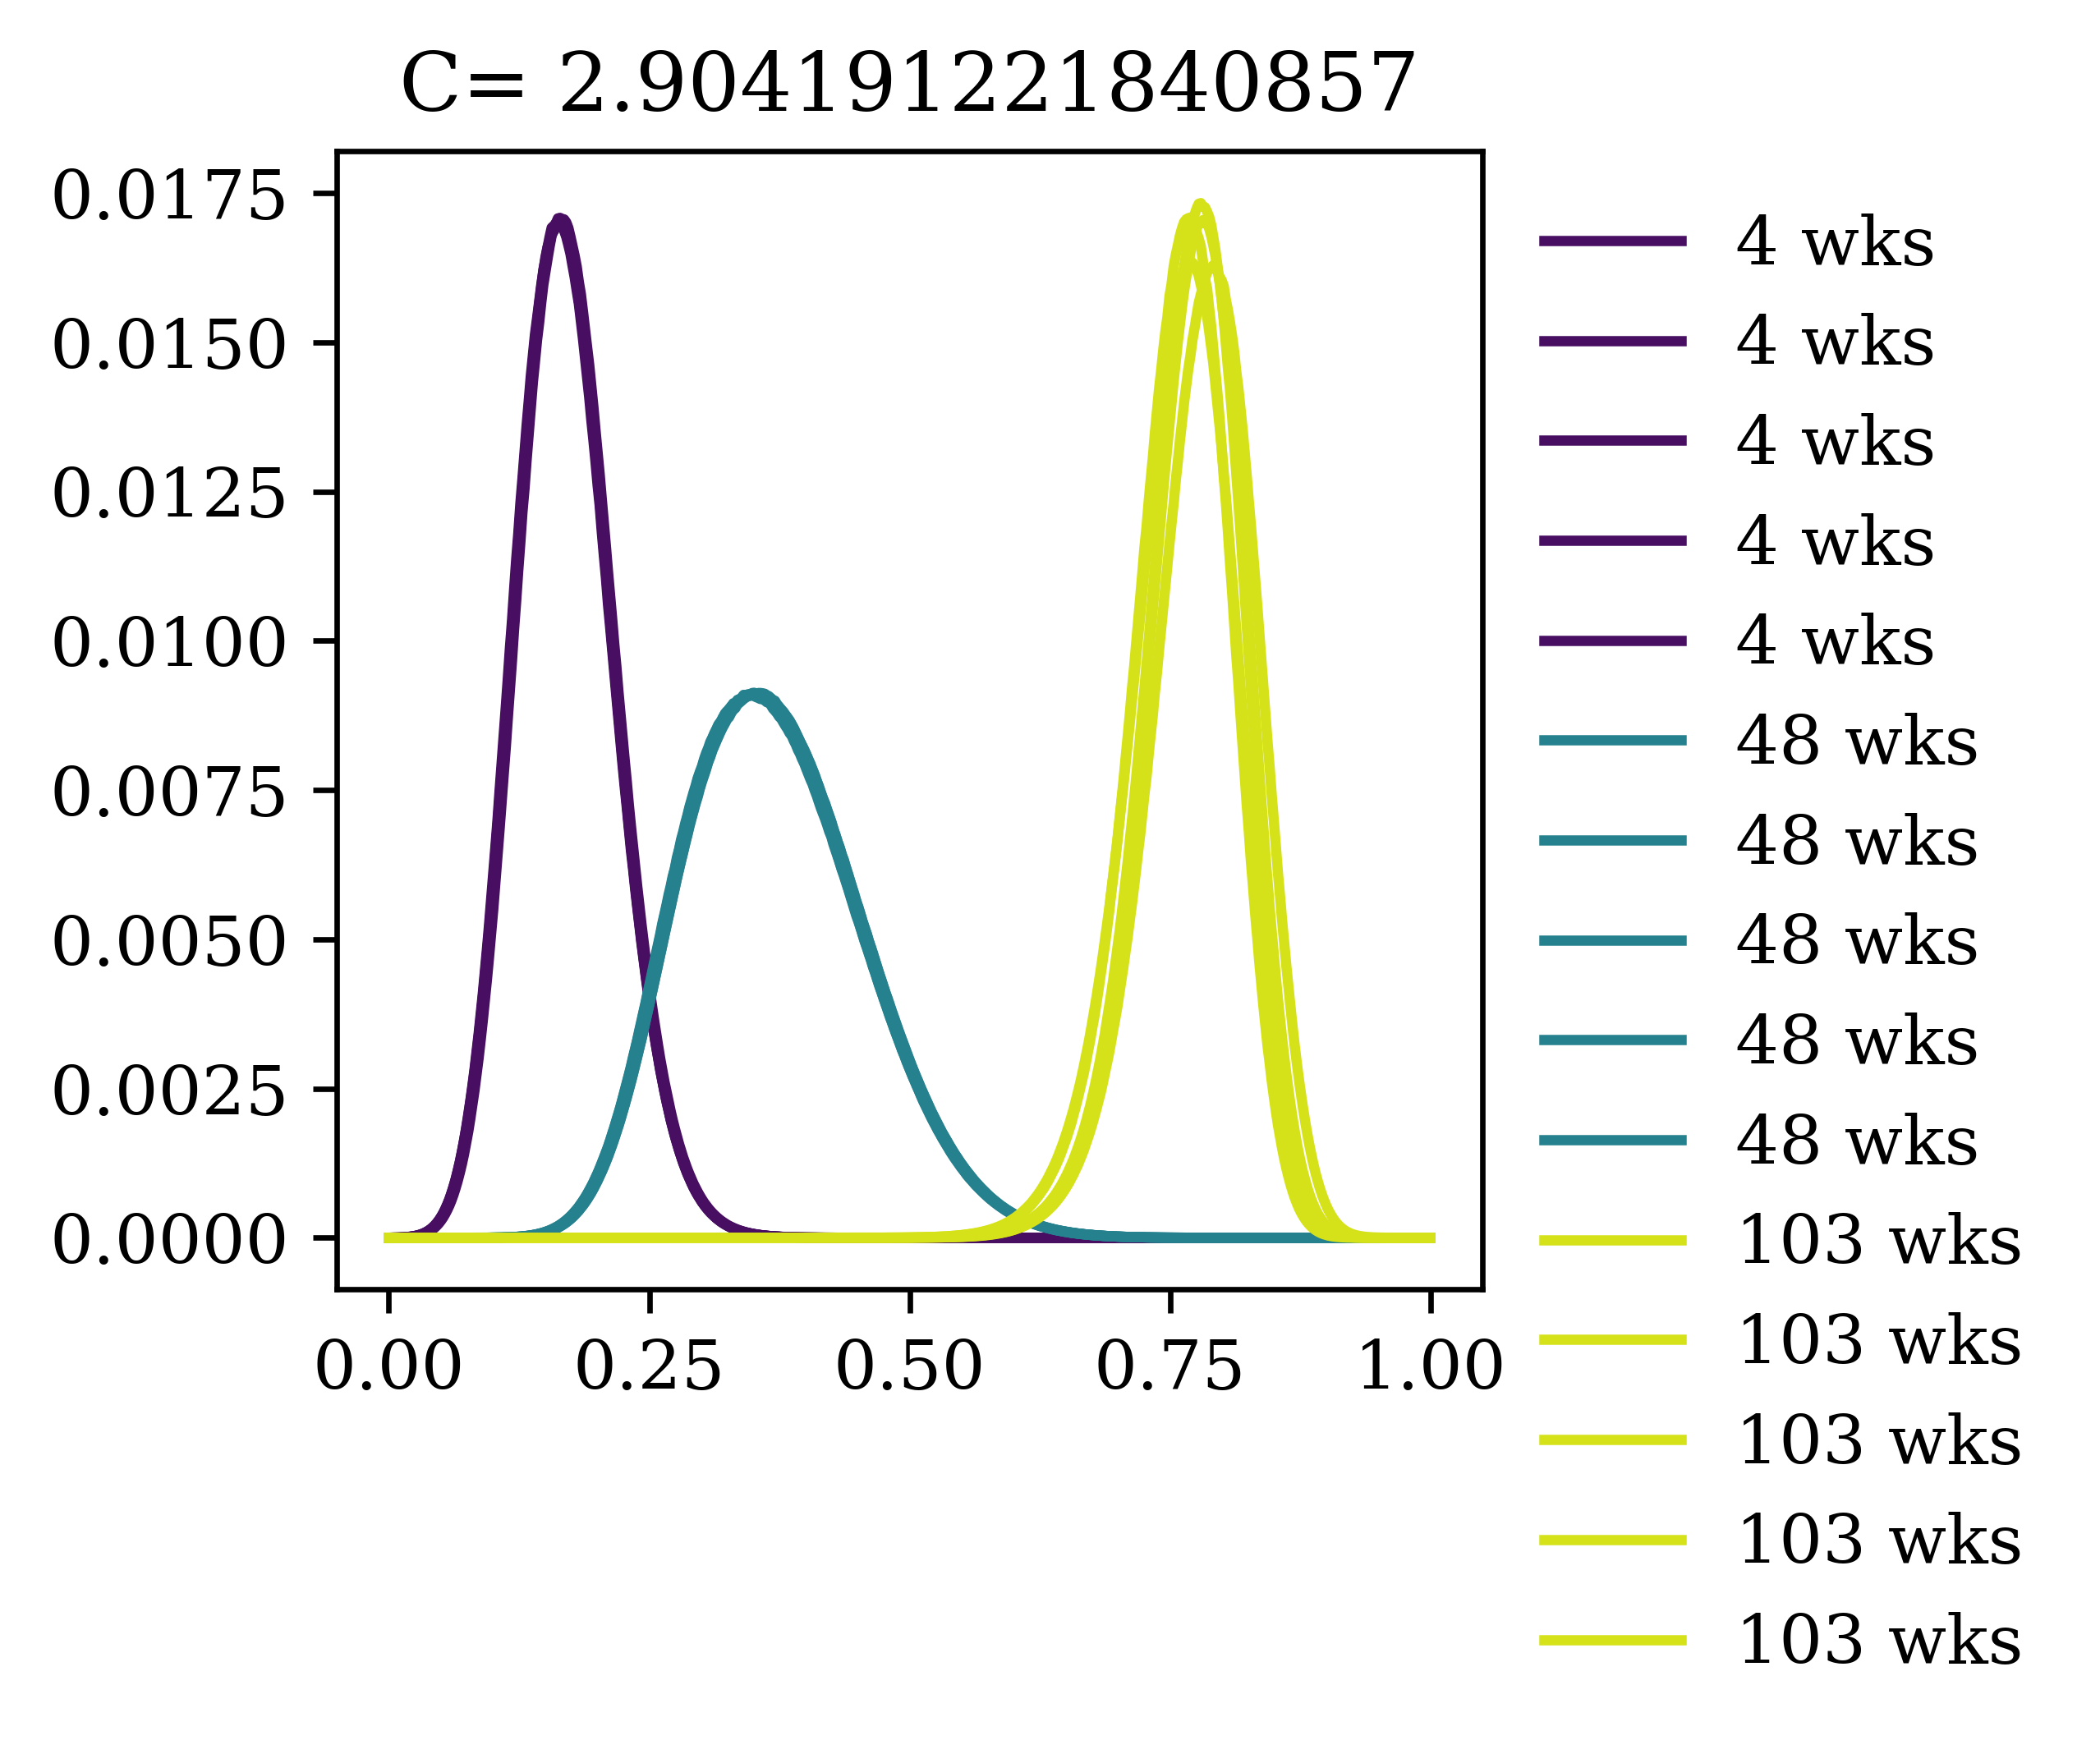

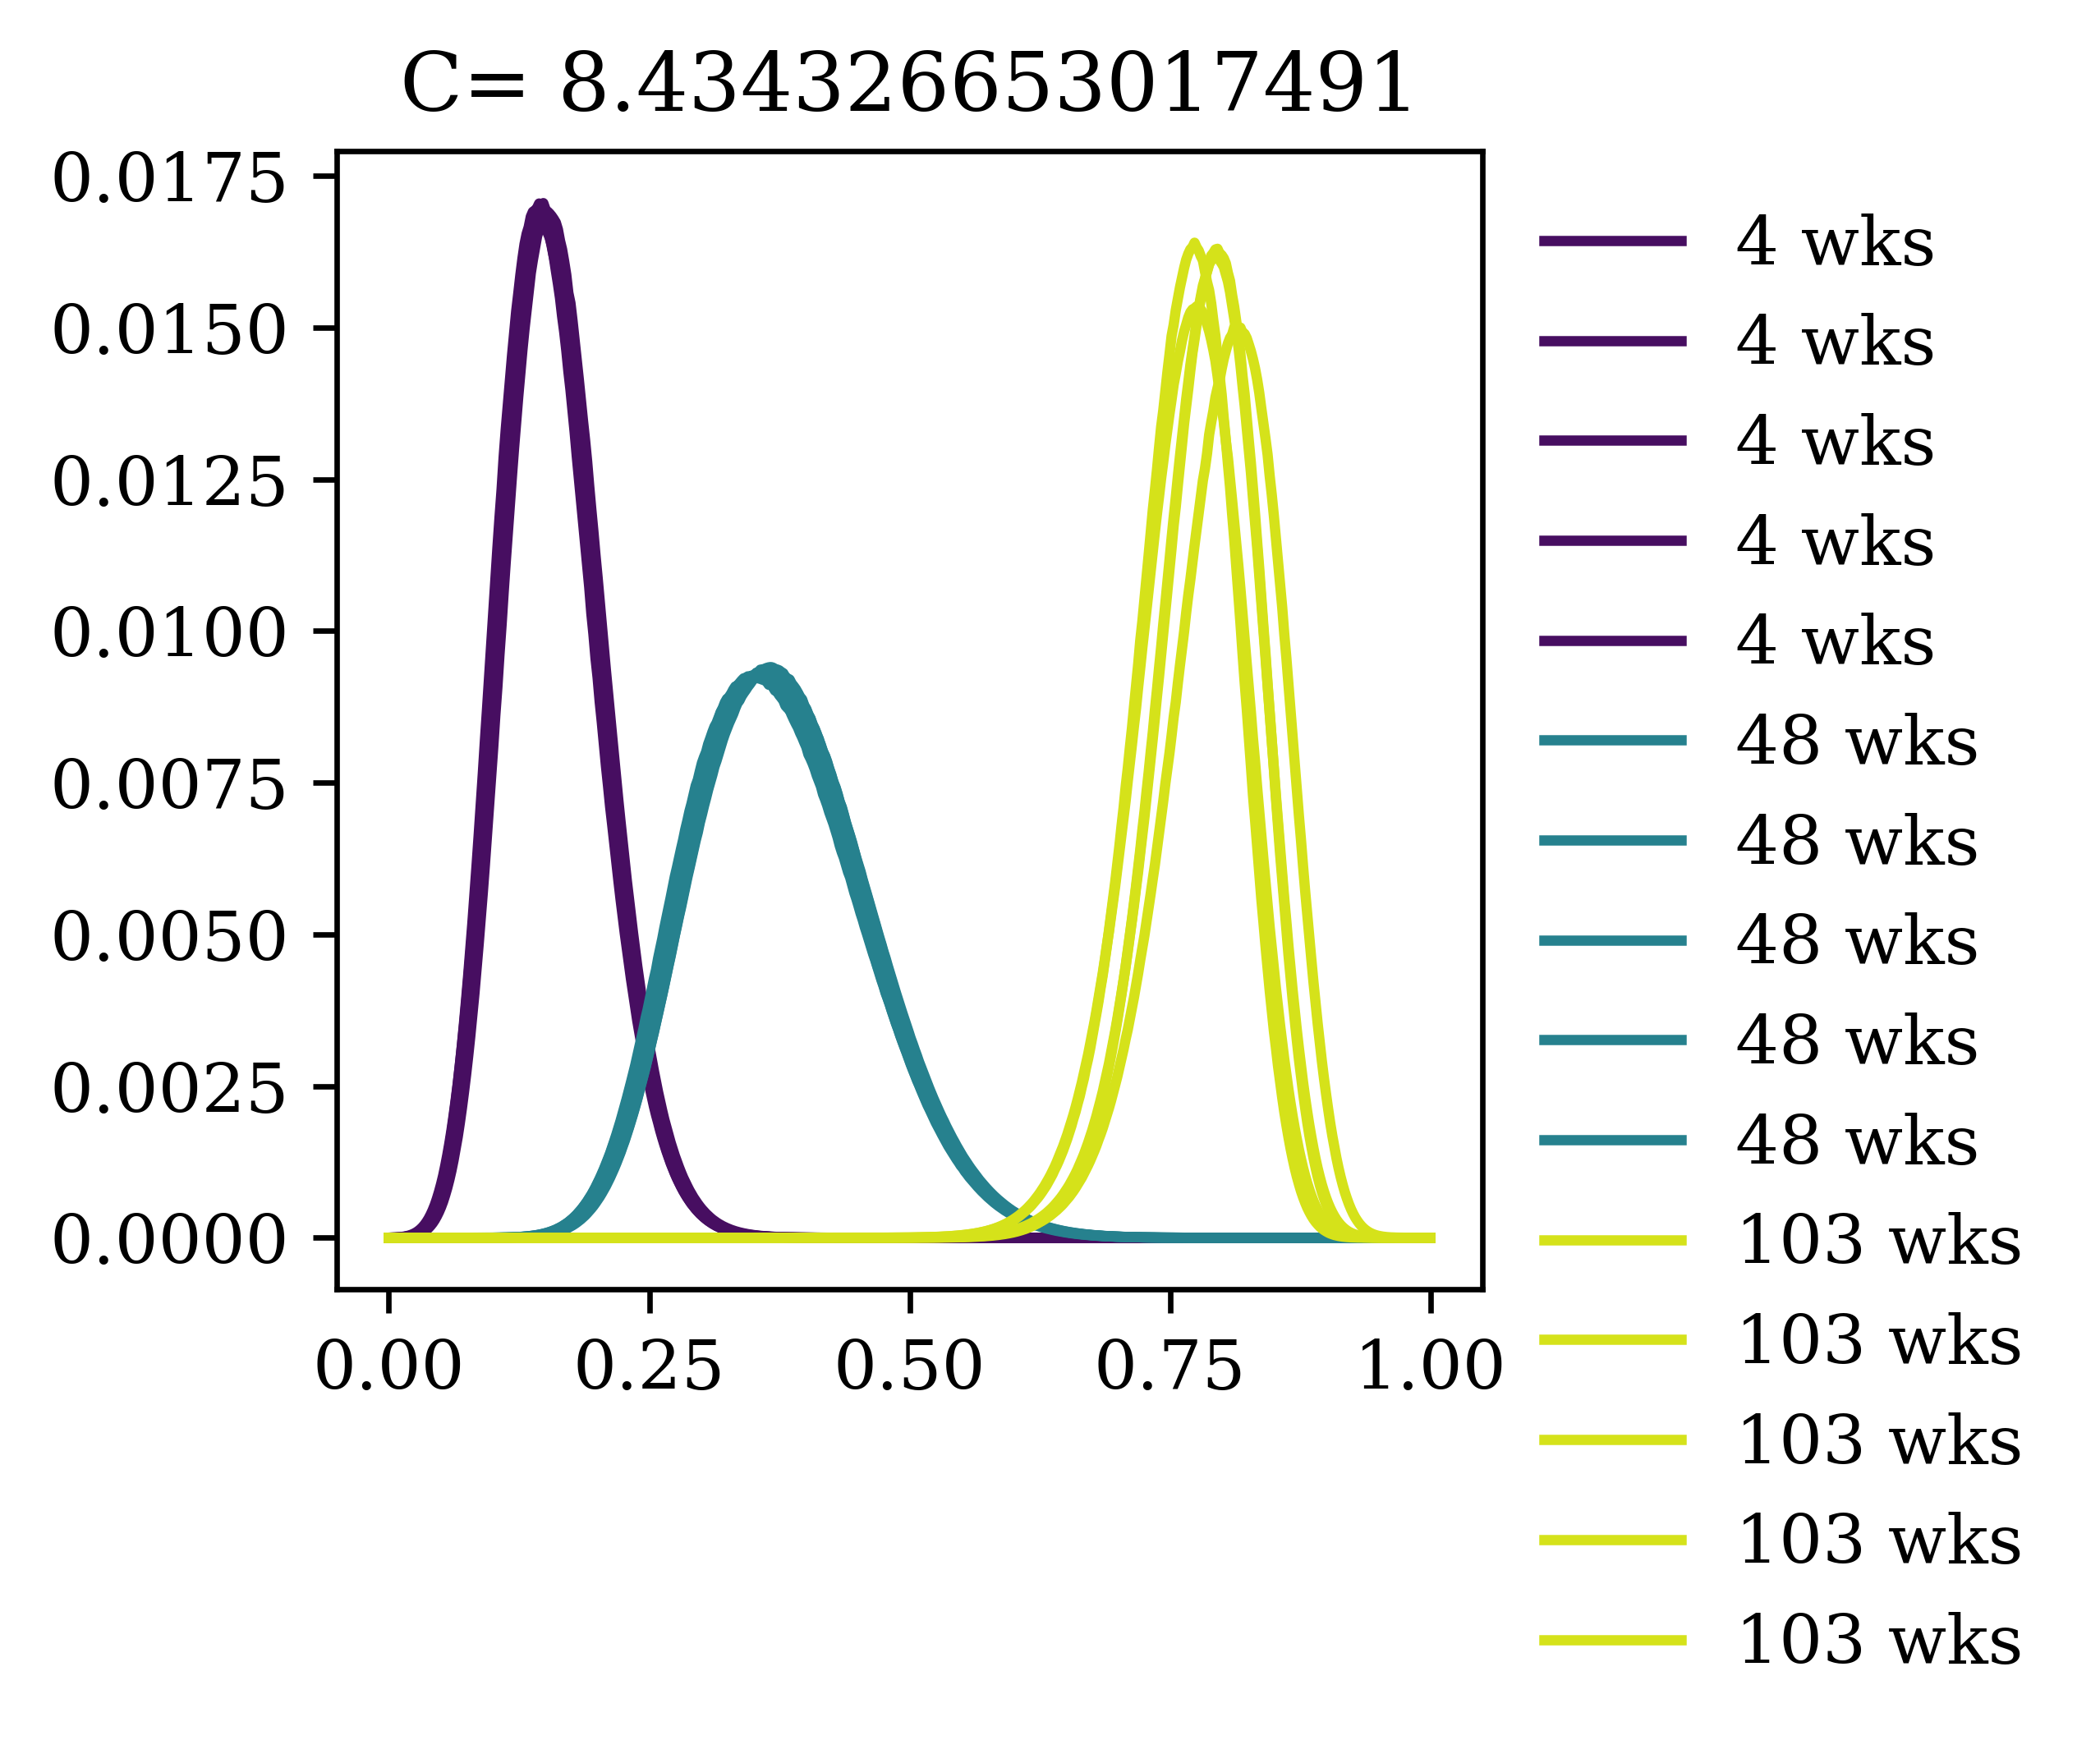

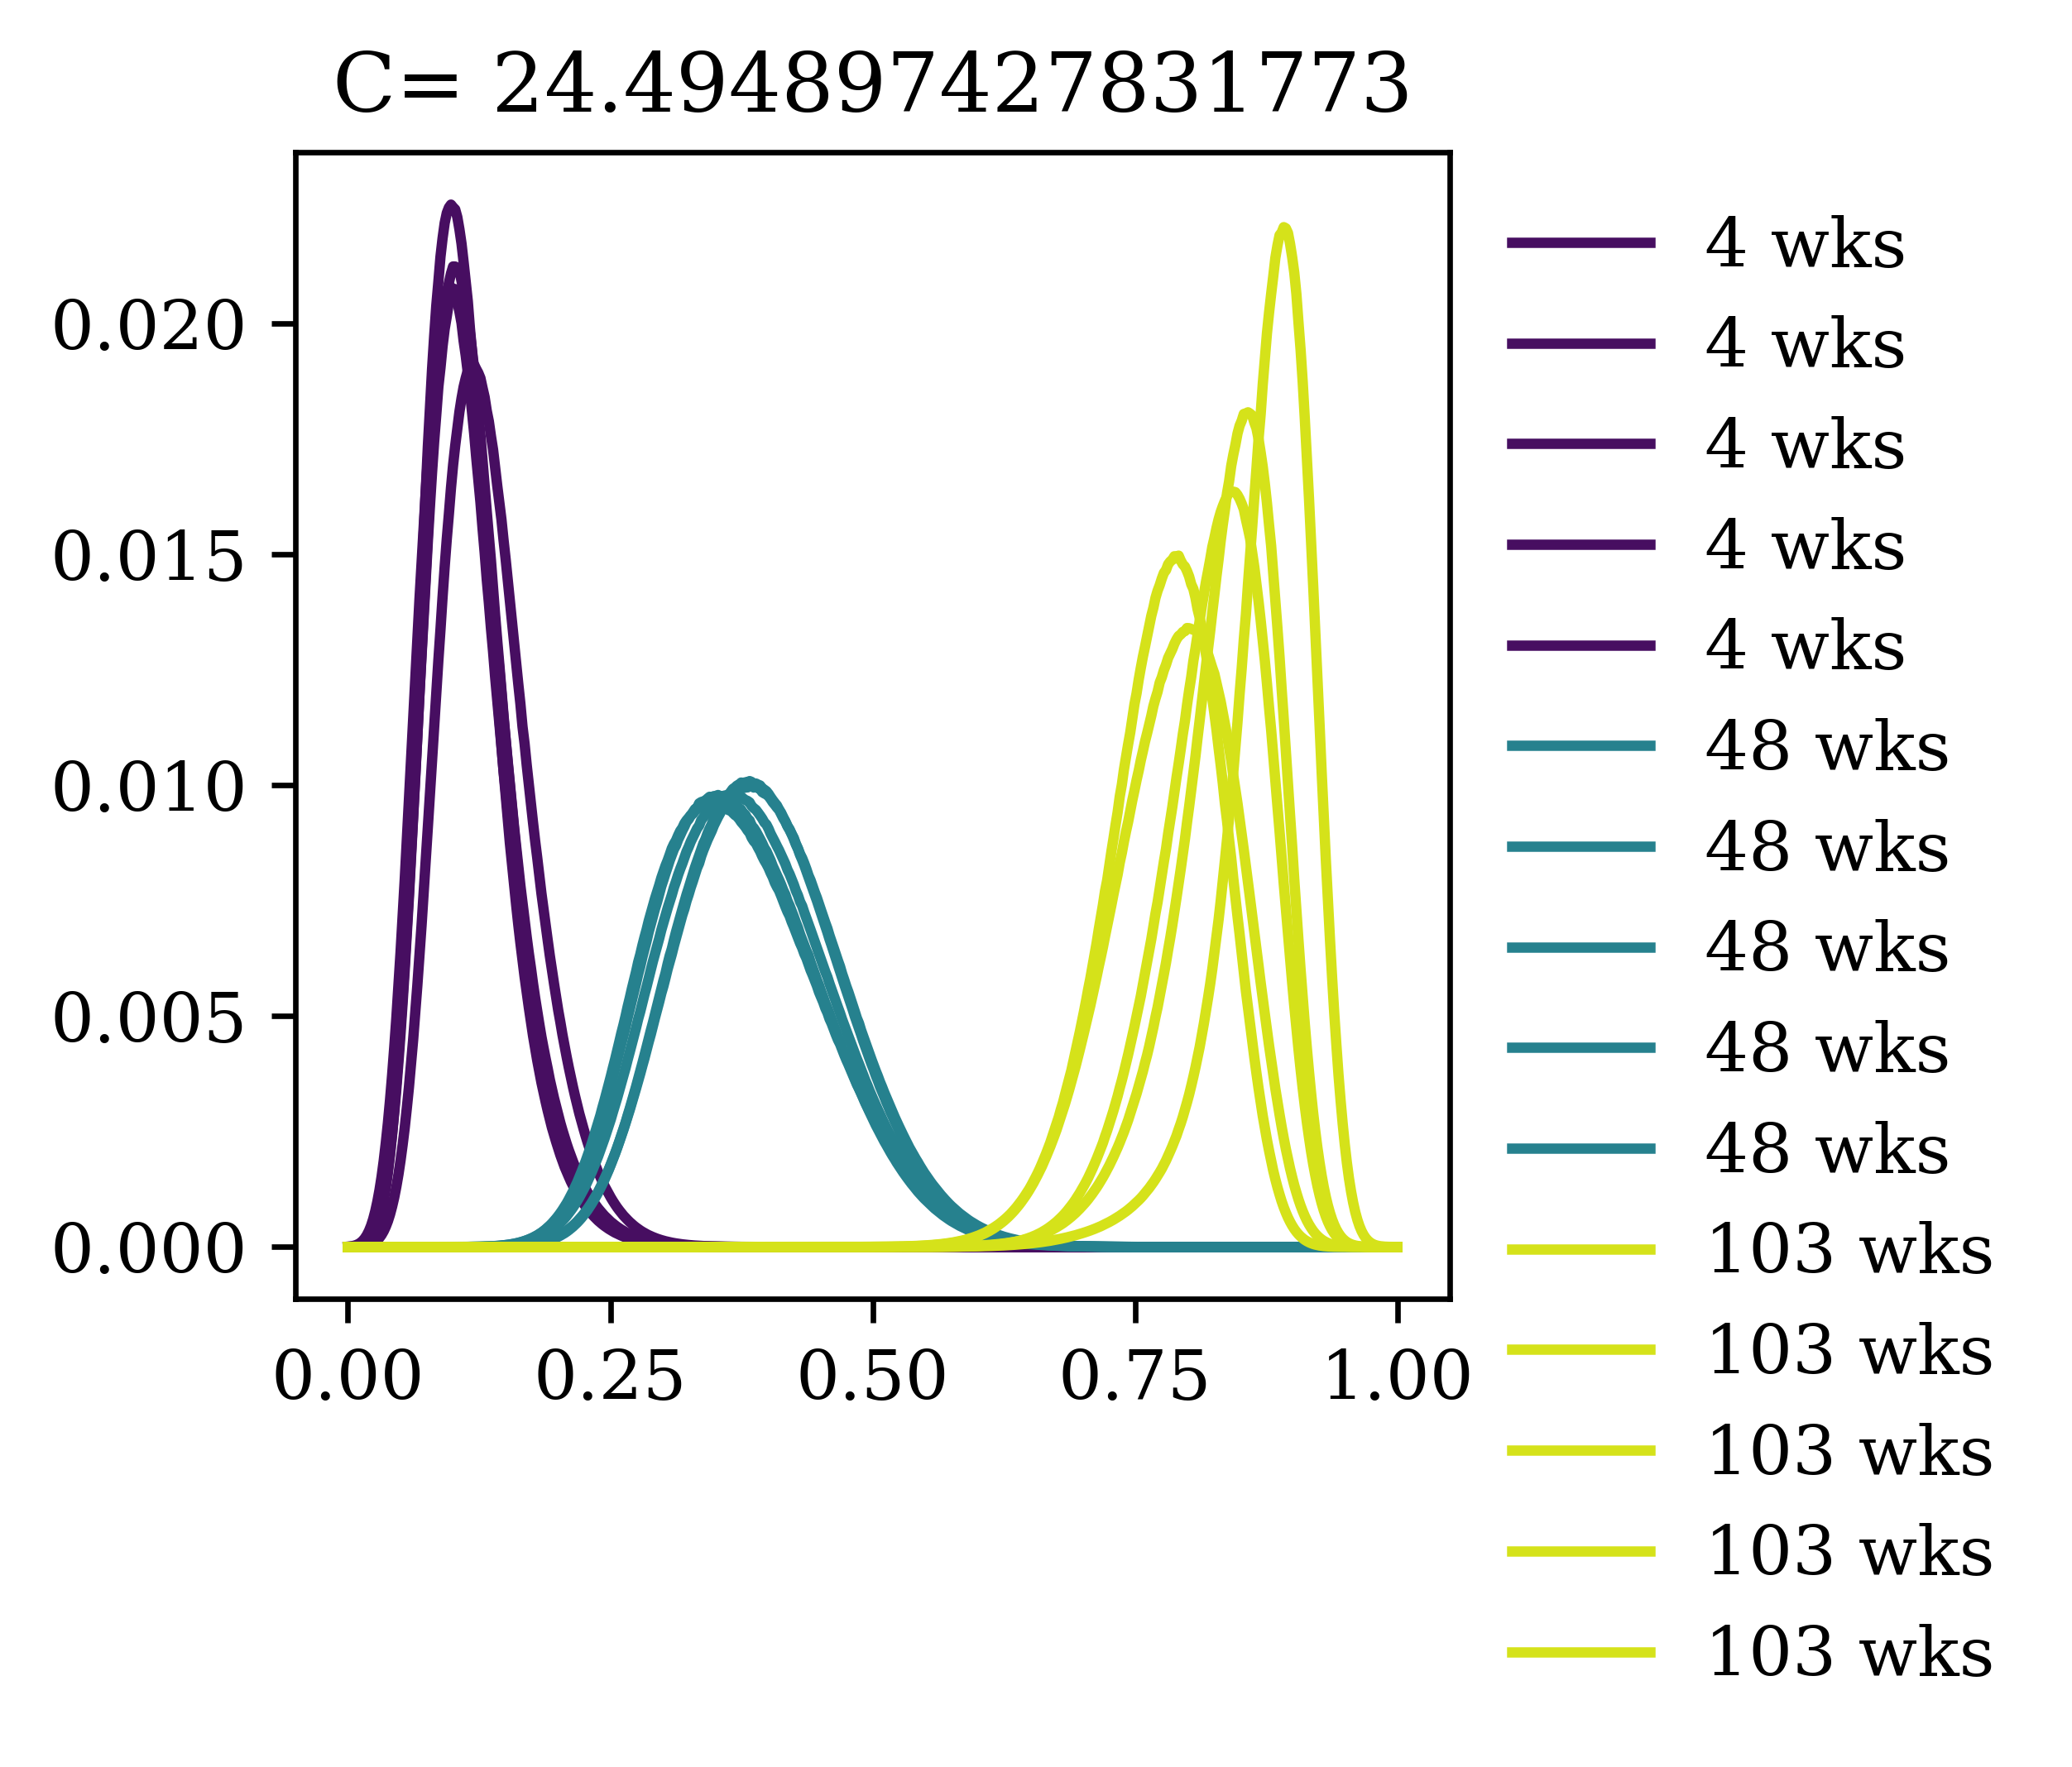

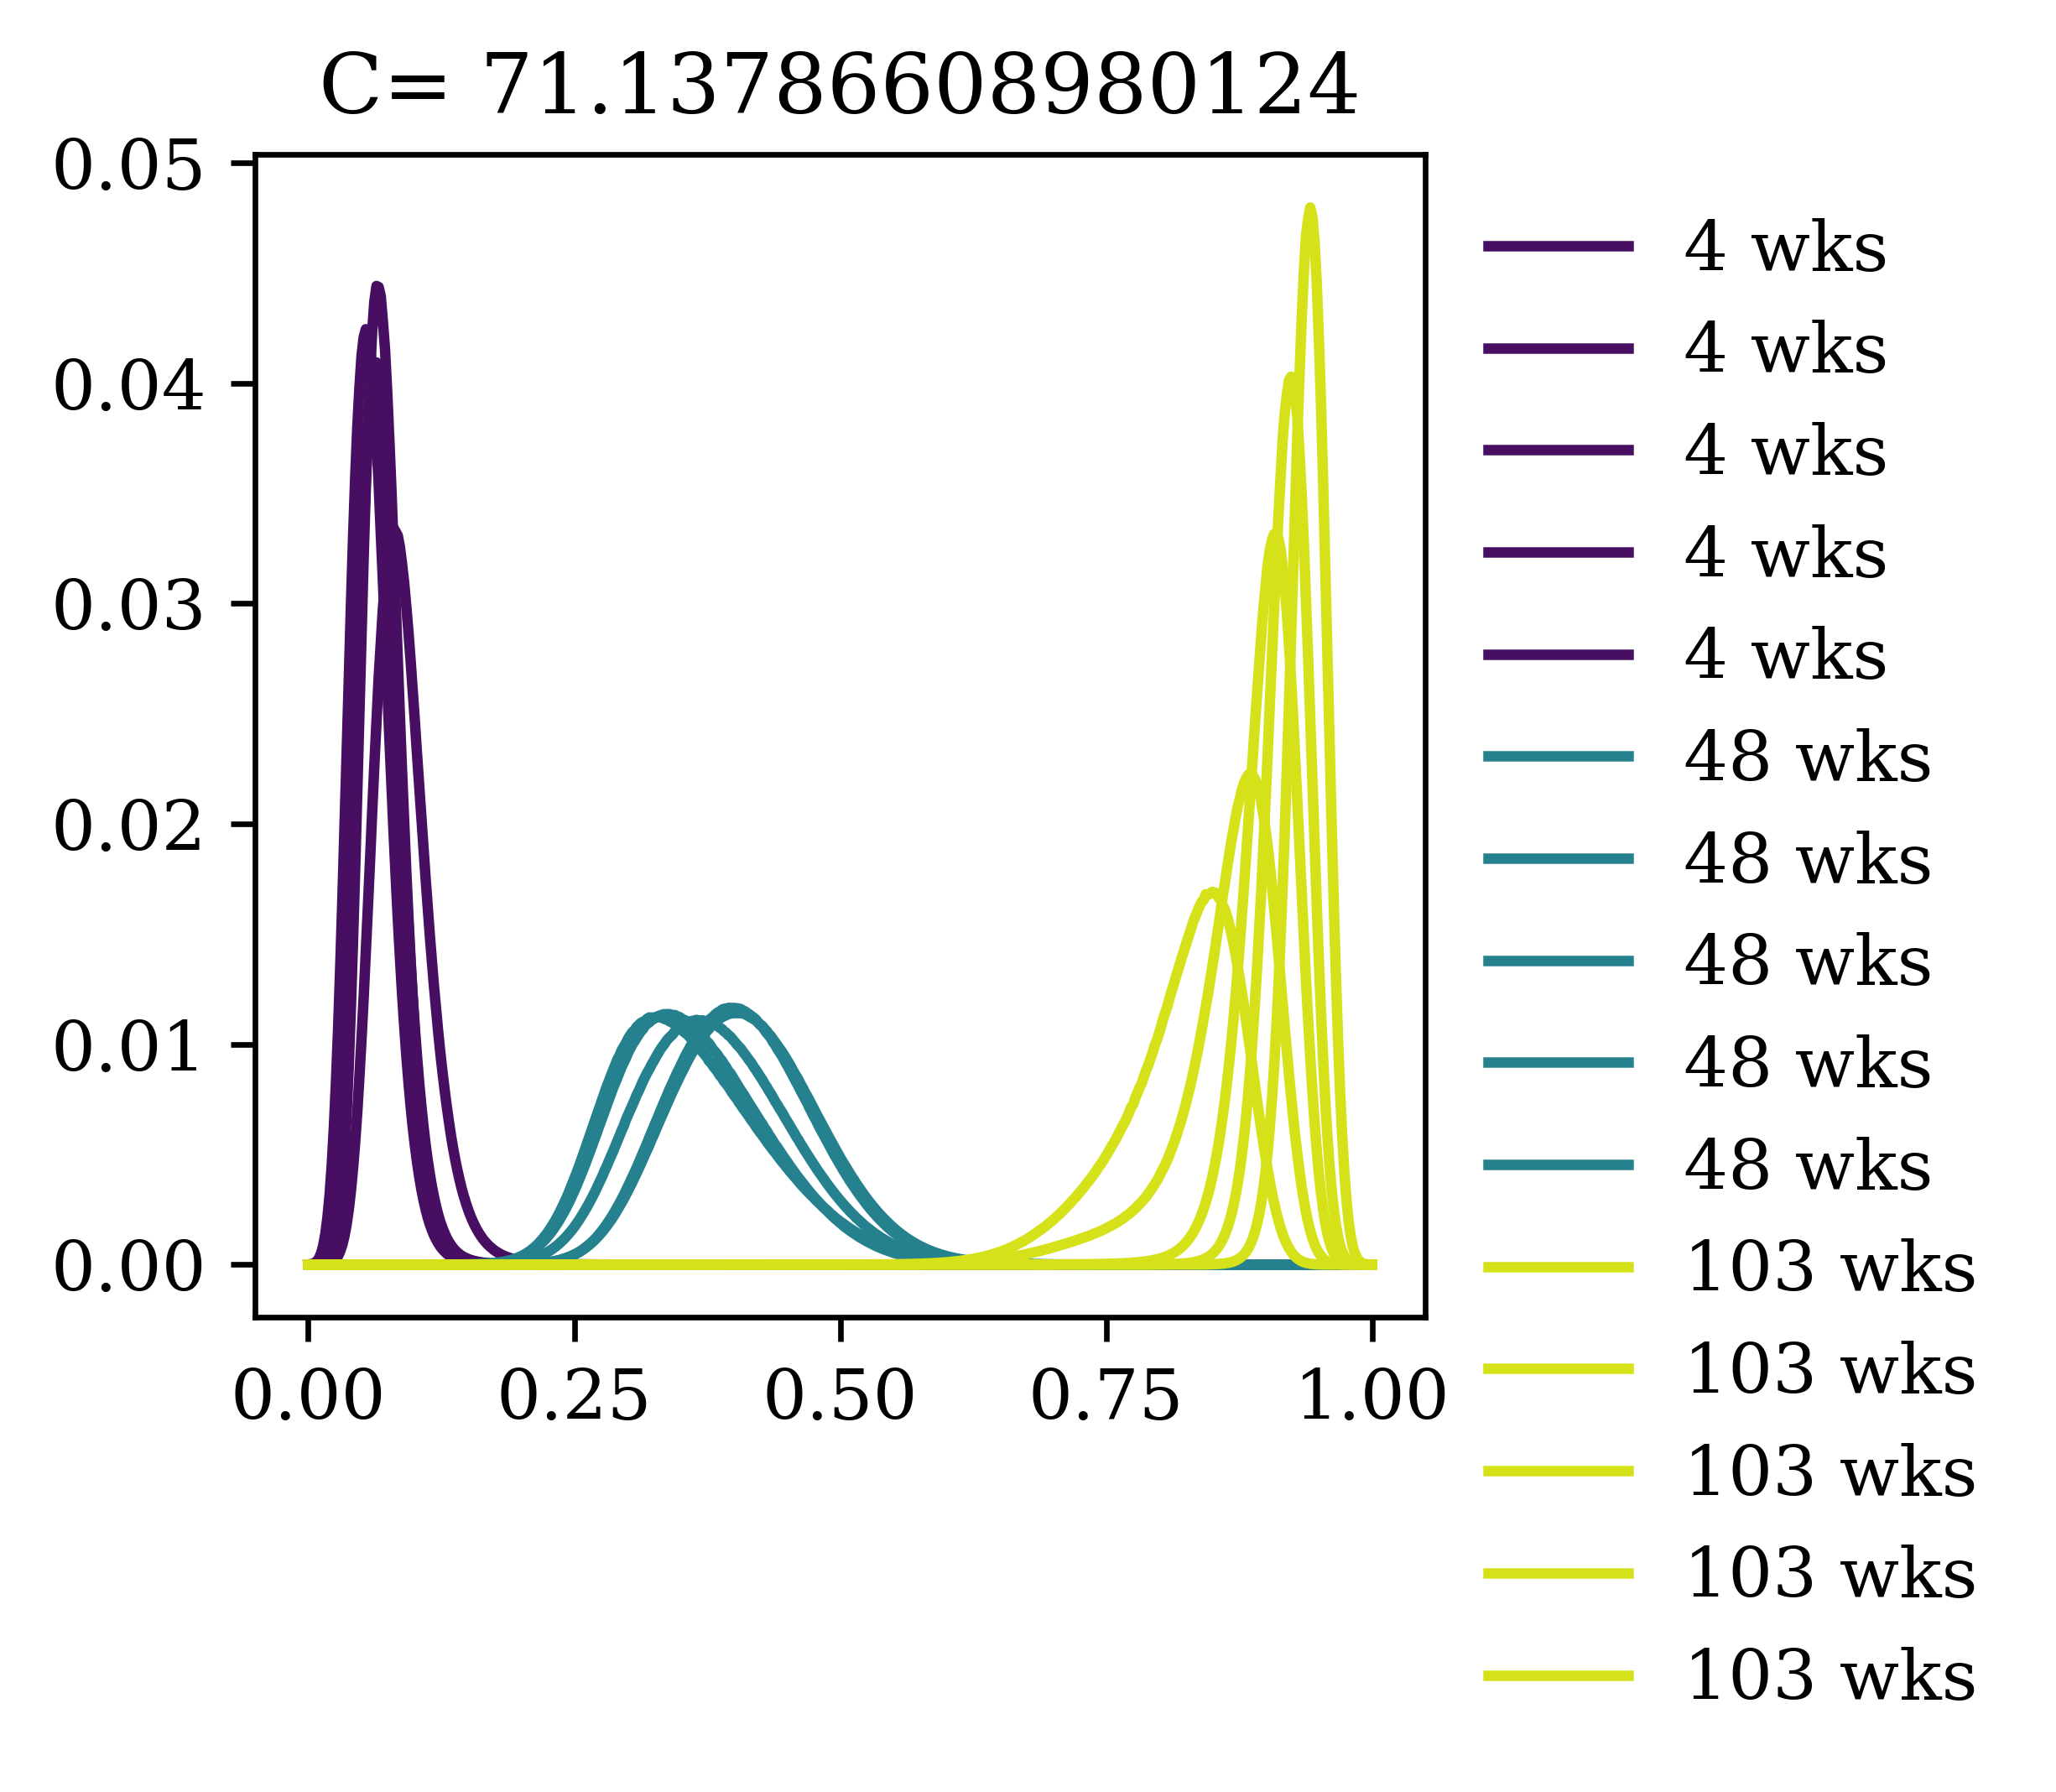

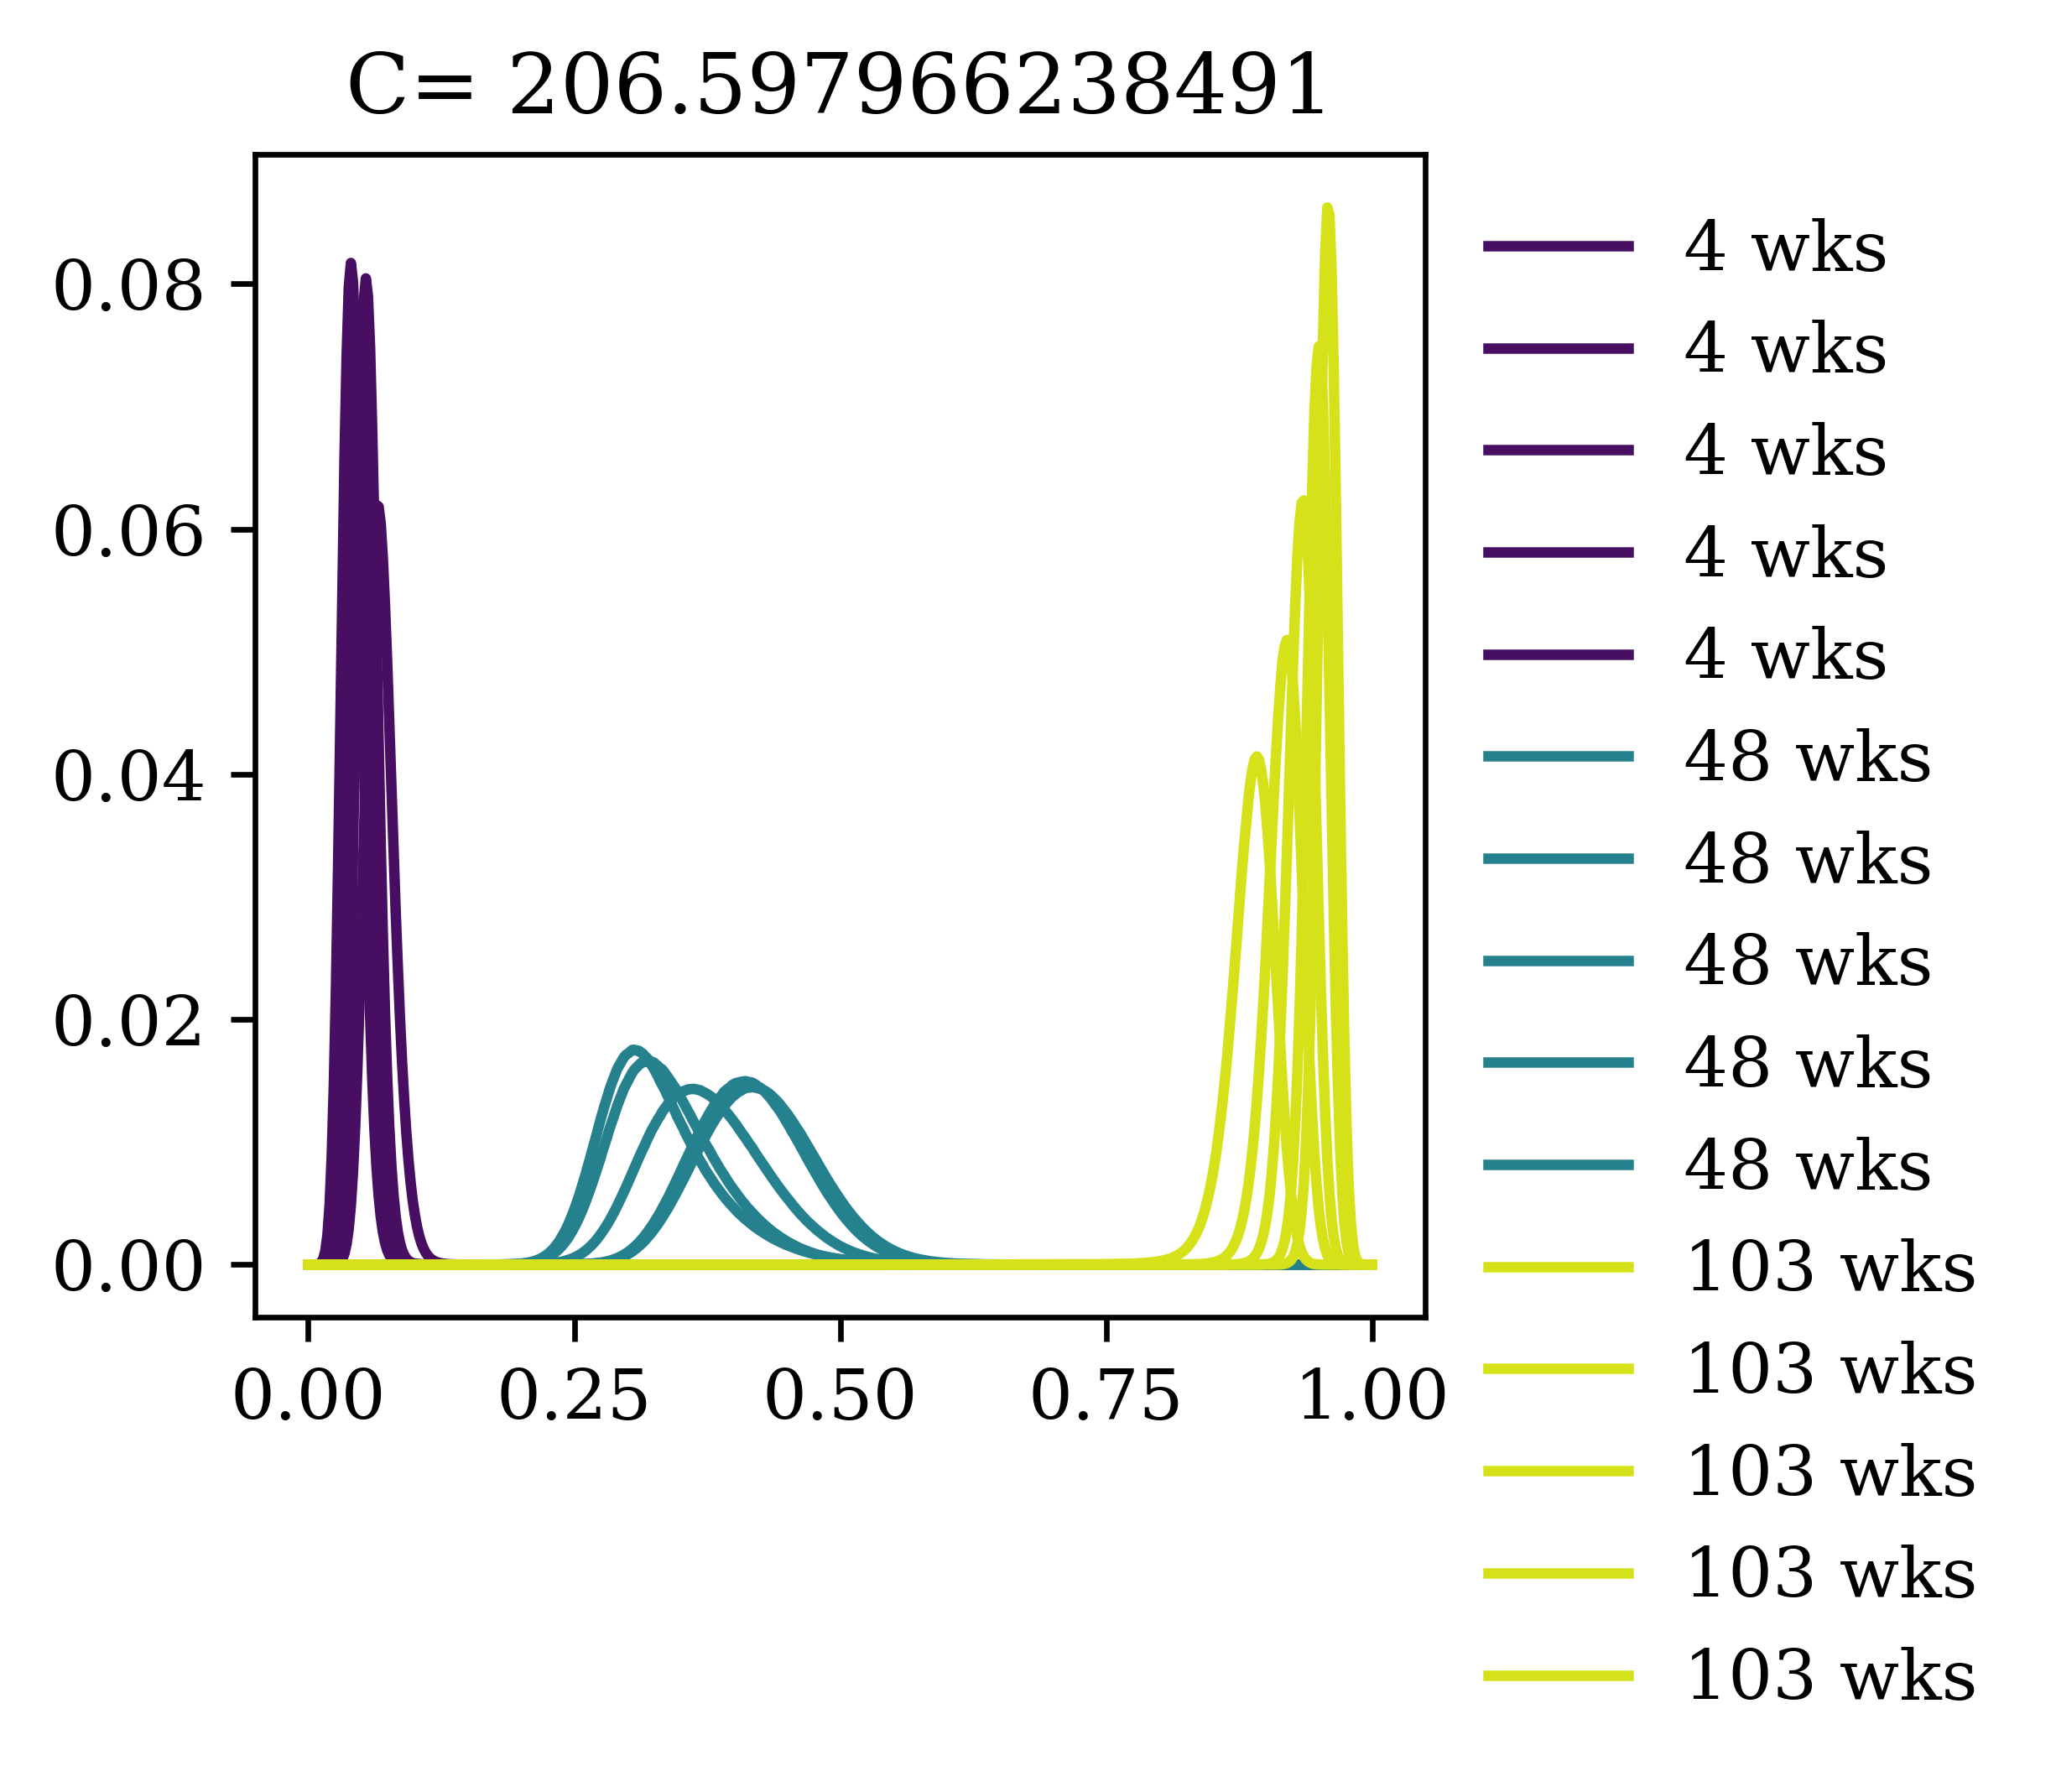

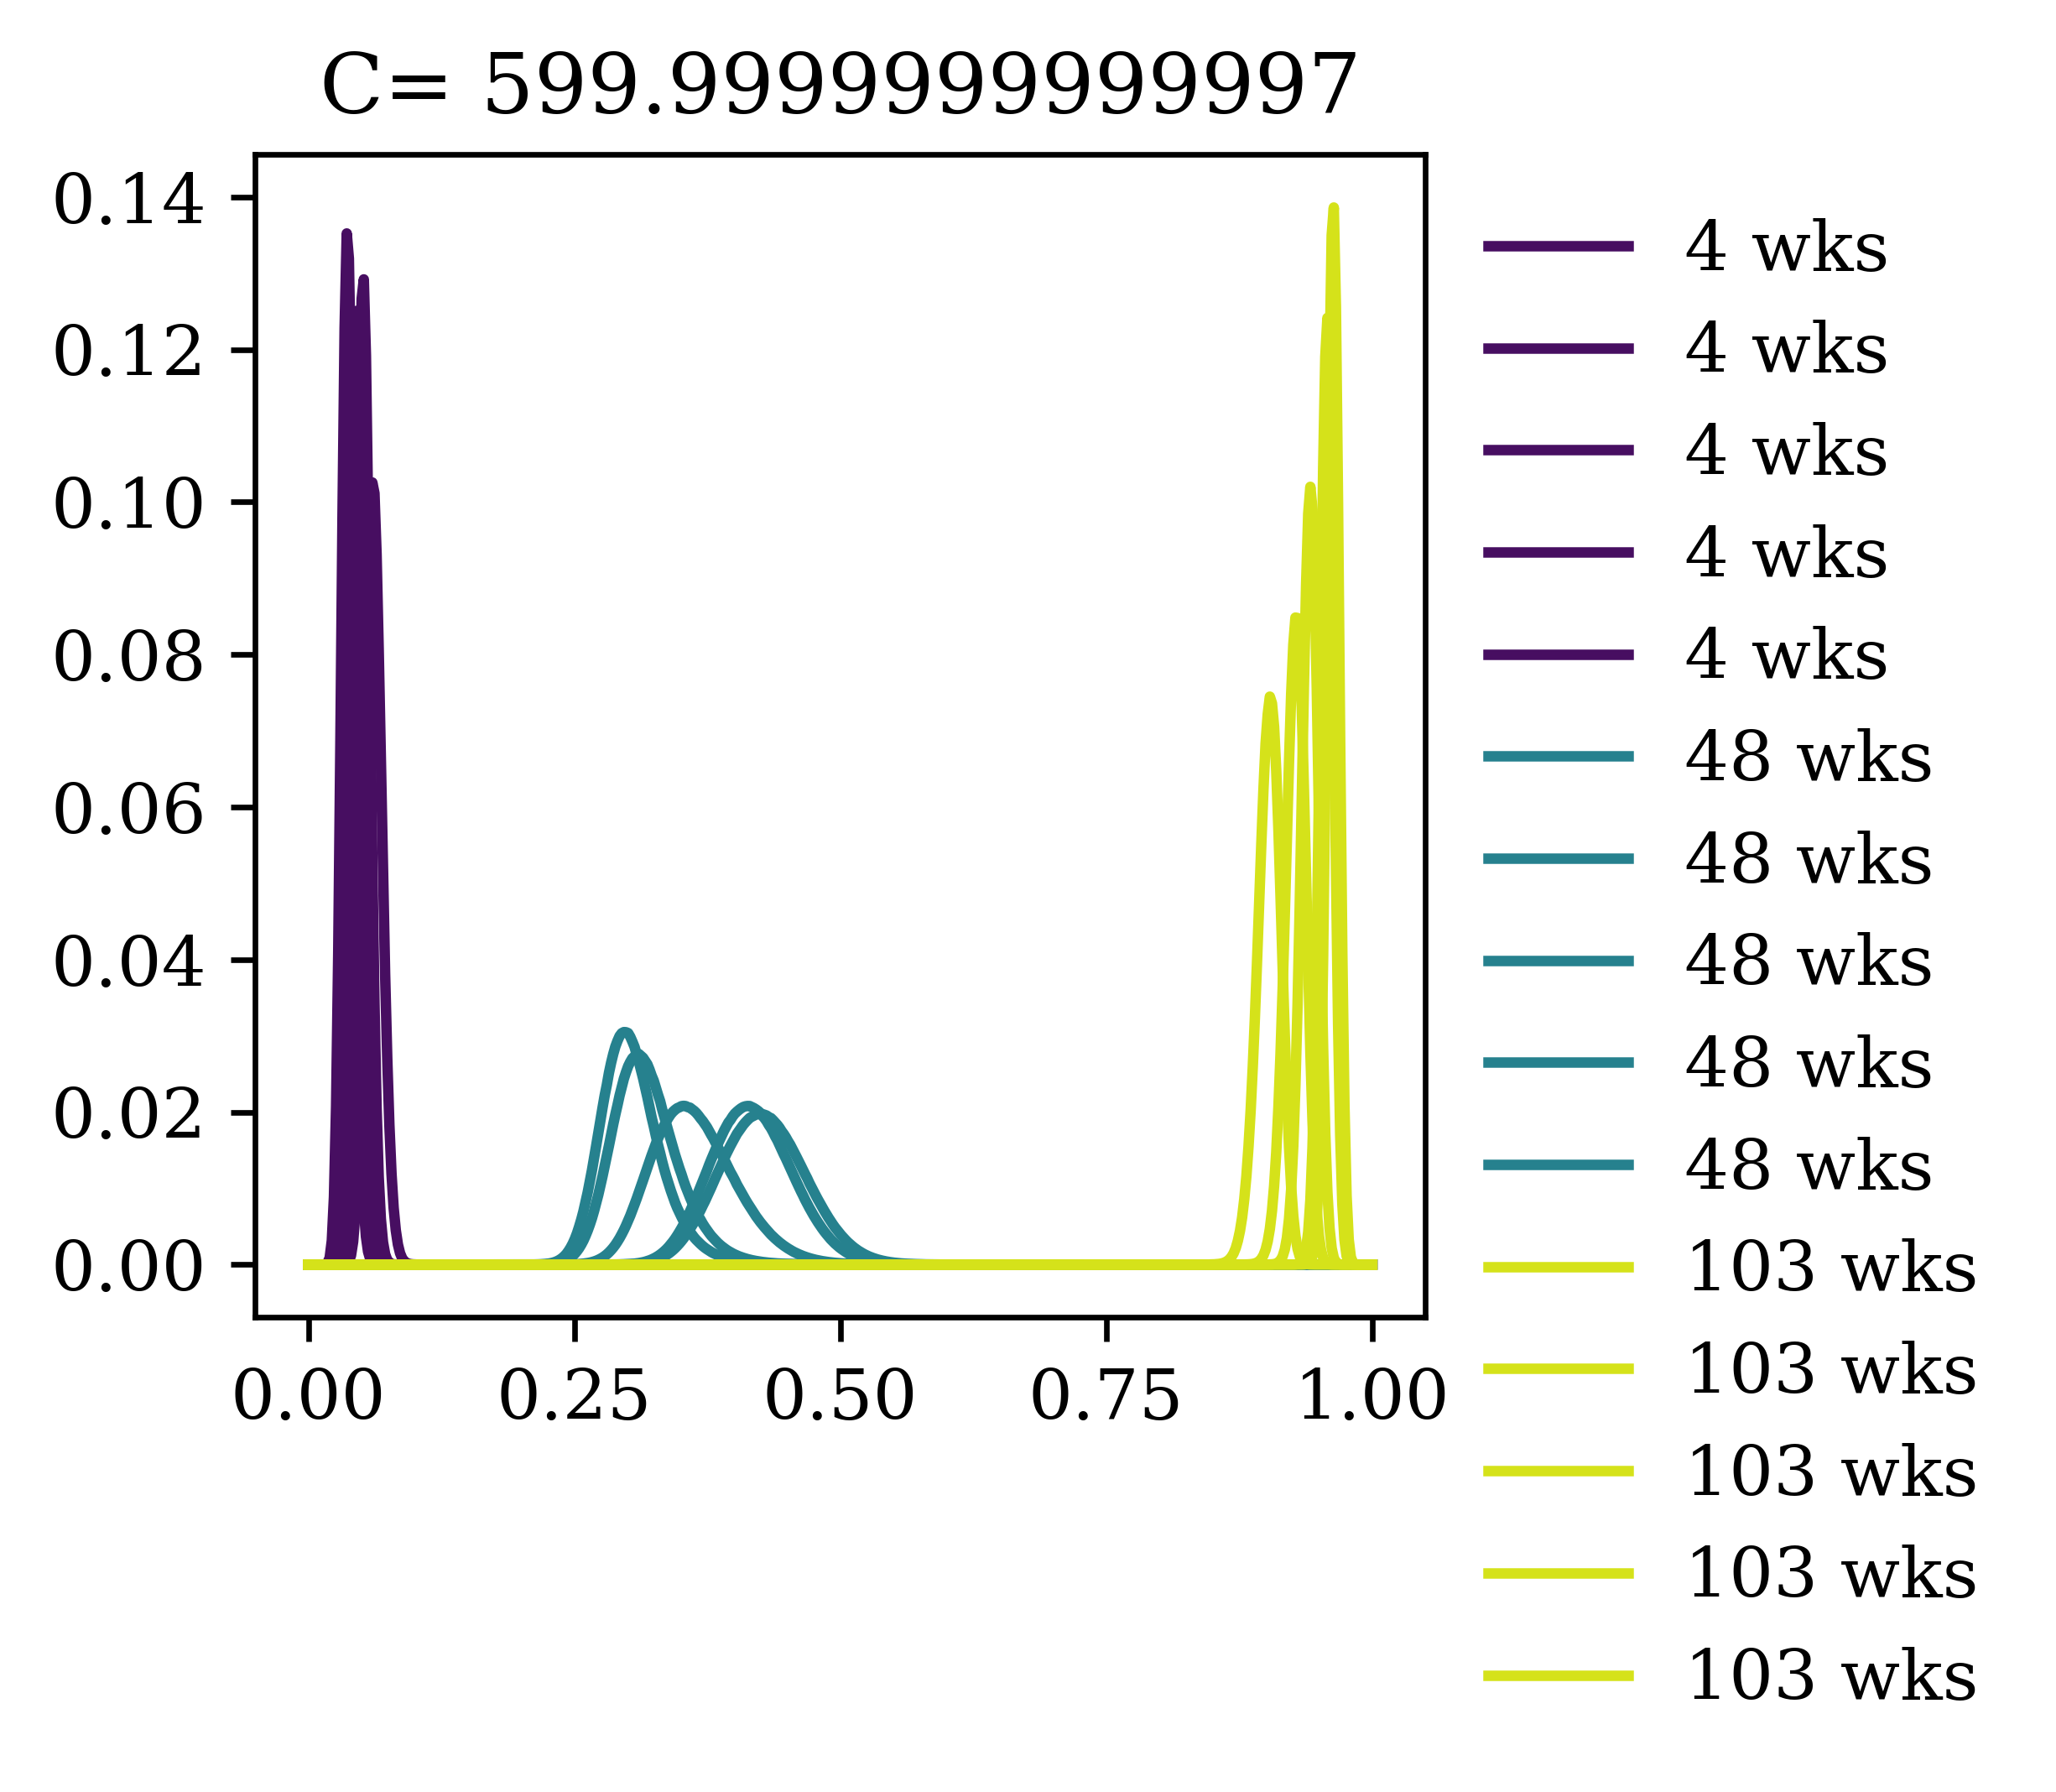

In [223]:
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(0, 110)

for factor, log_probs in factor_results.items():
    figure(3, 3)
    for idx, _age in zip(concatv(range(5), range(160, 165), range(-5, 0)), [4] * 5 + [48] * 5 + [103] * 5):
        c = cmap(norm(_age))
        plt.plot(age_x, jax.nn.softmax(log_probs[idx].T), label=f"{_age} wks", color=c)
    plt.title(f"C= {factor}")
    legend()

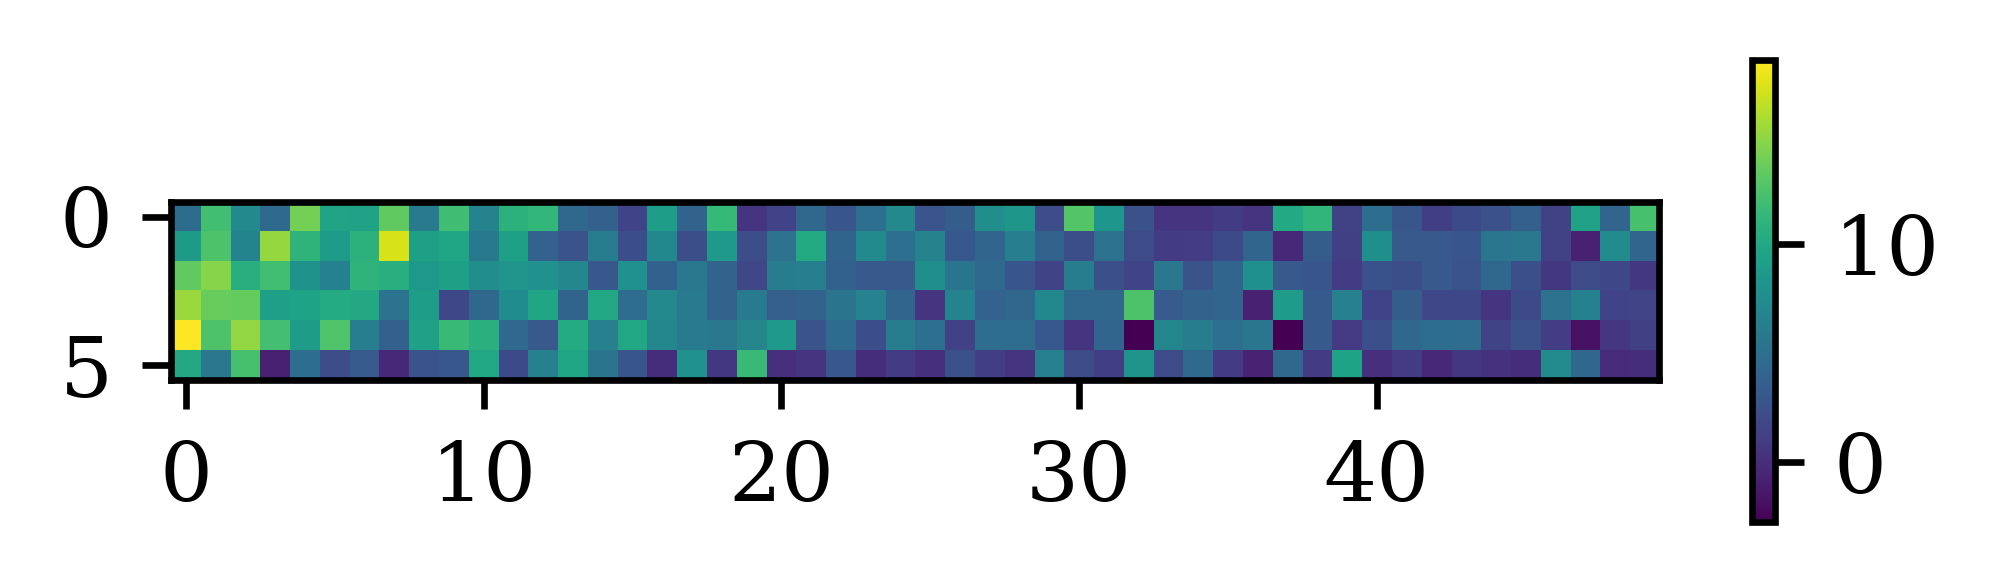

In [158]:
figure(4, 1)
plt.imshow(optimized_params['basis_weights'].T)
plt.colorbar()

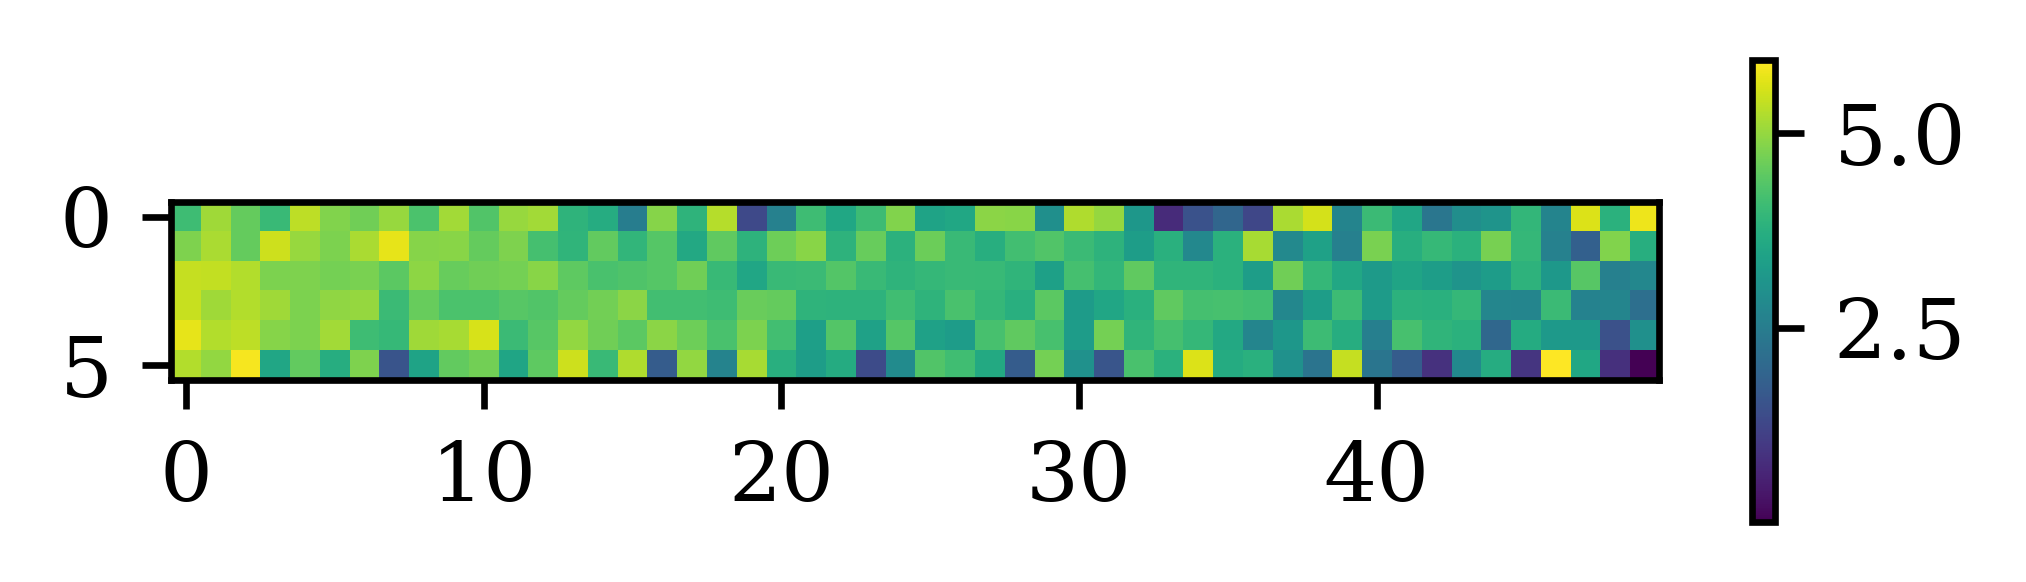

In [159]:
figure(4, 1)
plt.imshow(theta)
plt.colorbar()


<Axes: >

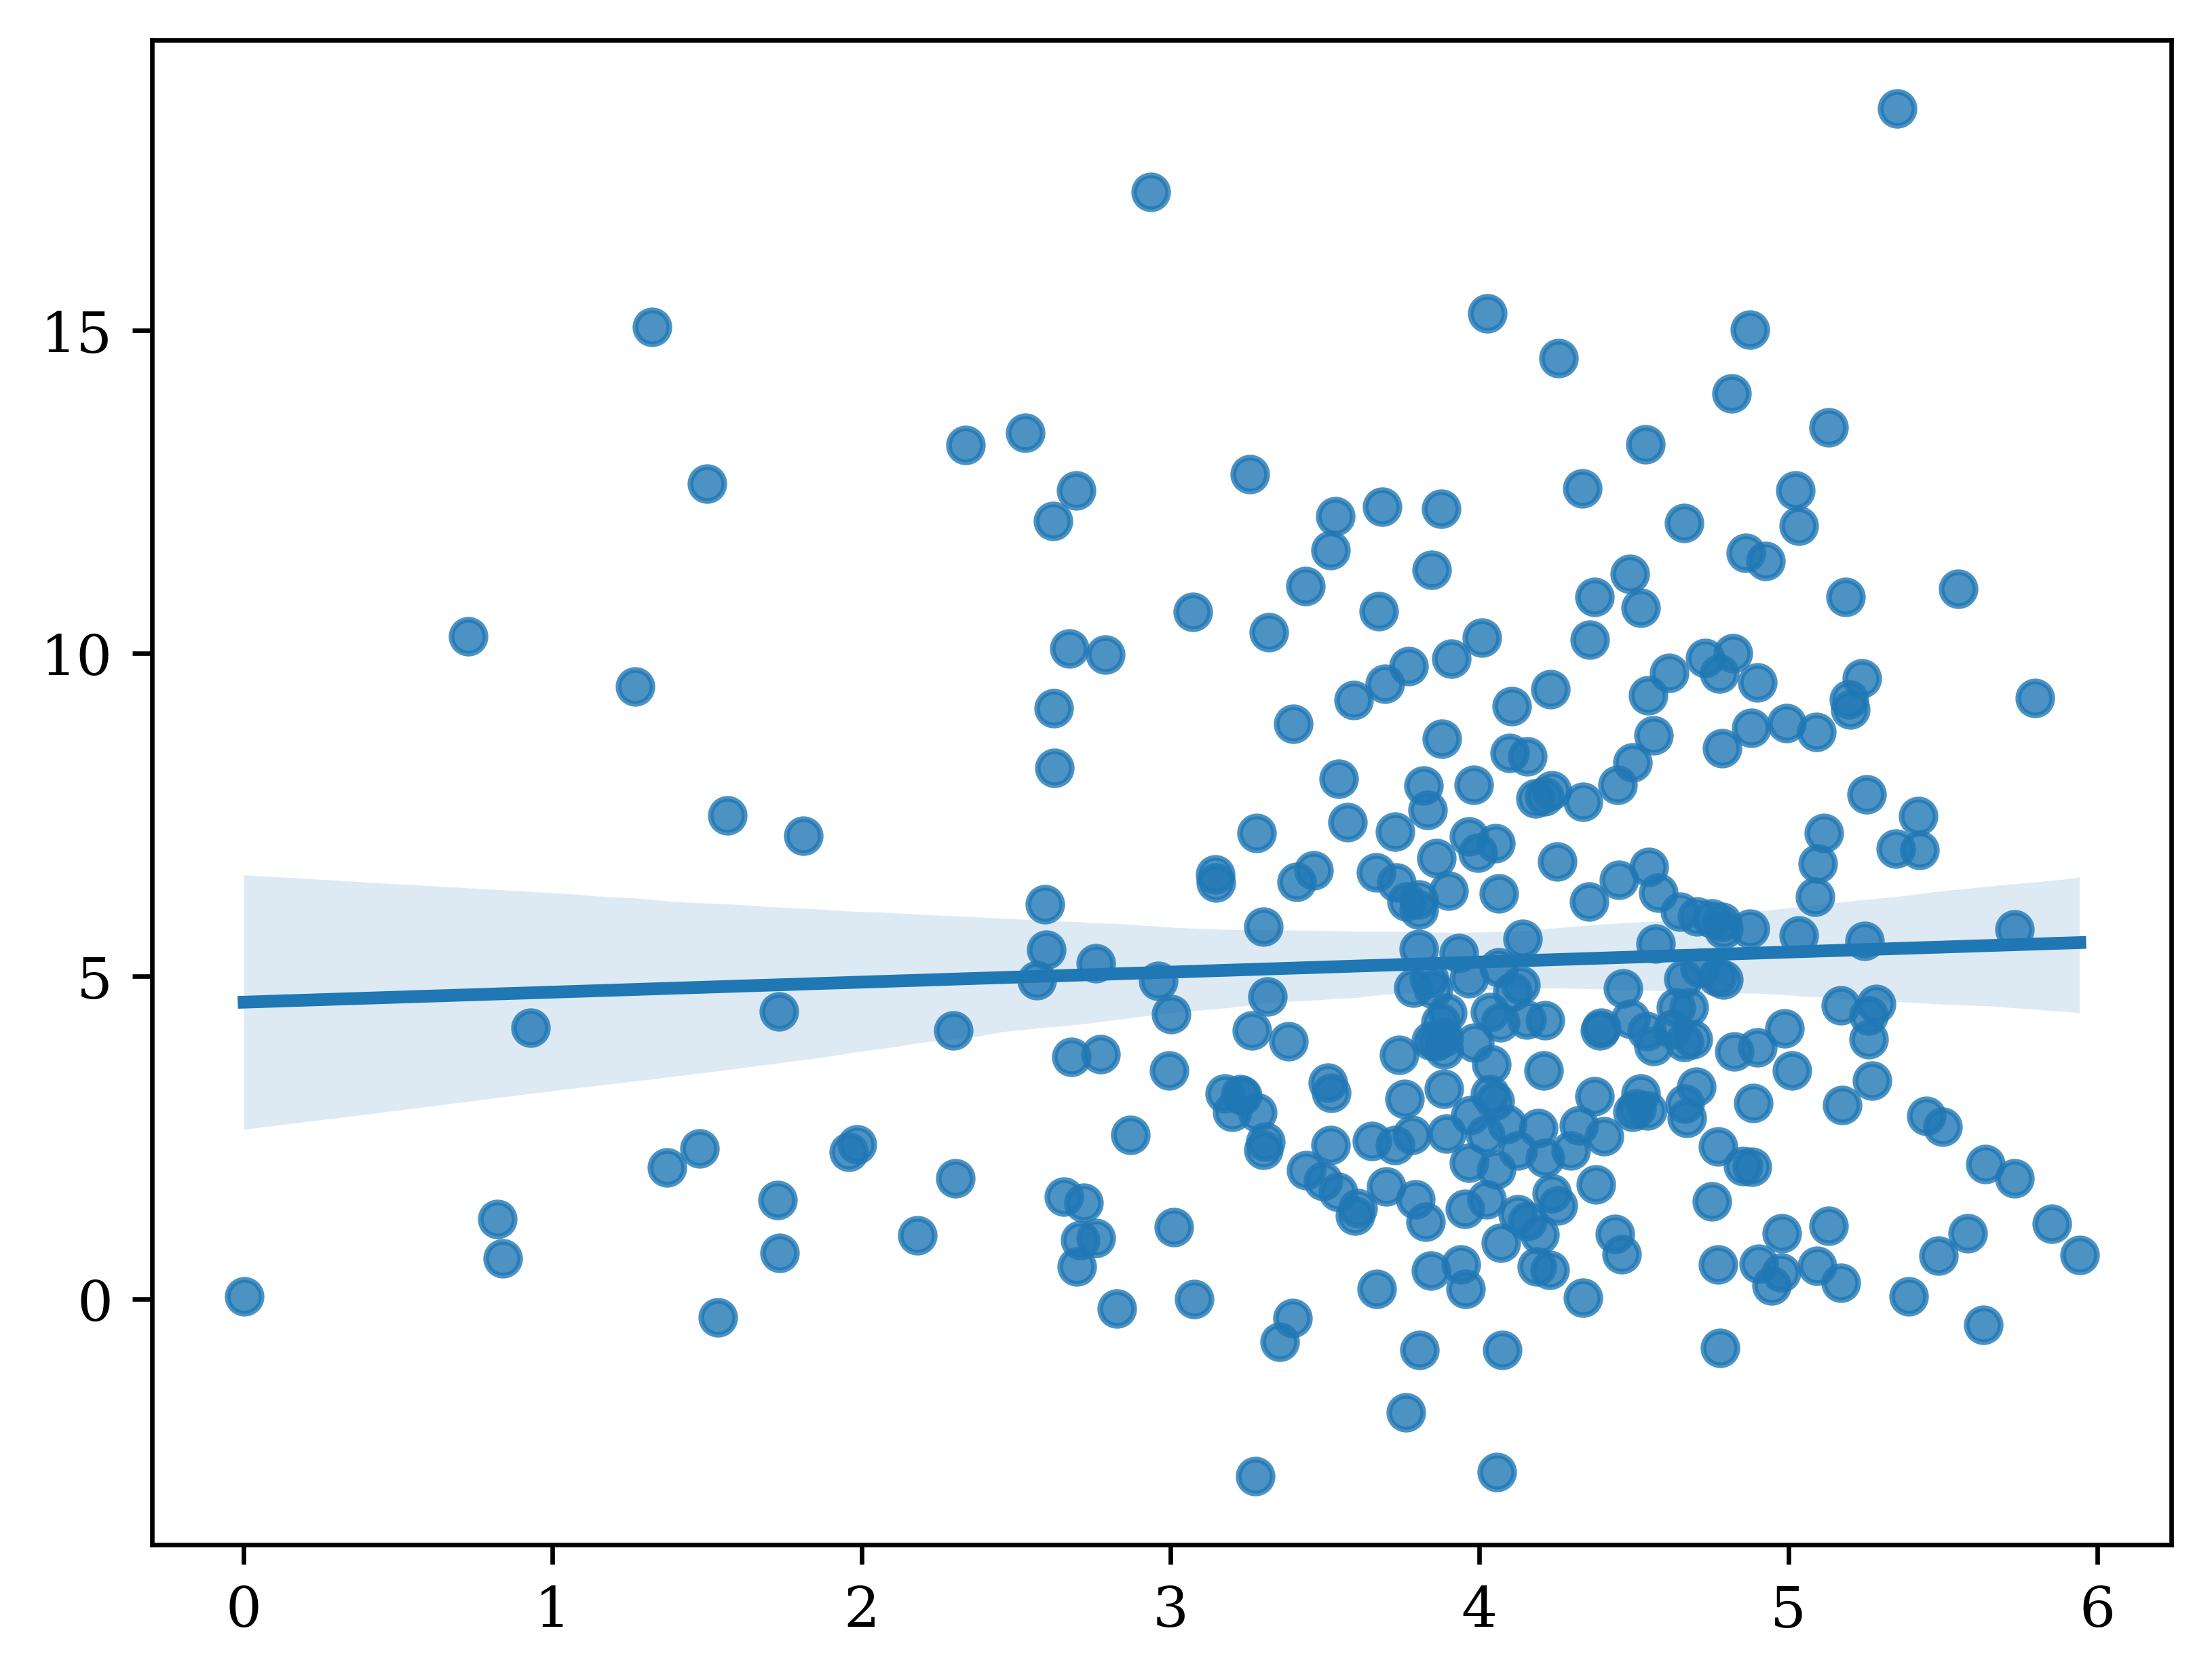

In [162]:
sns.regplot(x=theta.flatten(), y=optimized_params['basis_weights'].flatten())

## Fit with a pseudocount of ~100

In [ ]:
usage_frequencies = (syllable_counts_jax + 1) / (syllable_counts_jax + 1).sum(axis=1)[:, None]

In [ ]:
# shape = k bases, n_sessions
bs = BSplines(np.linspace(0, 1, 1000), df=6, degree=3, include_intercept=True)
A = bs.transform(age_normalizer(age)).T

factor_results = {}
for factor in pseudocount_factor:
    freqs = usage_frequencies * factor
    theta, *_ = np.linalg.lstsq(A.T, np.log(freqs), rcond=None)
    age_x = age_normalizer(jnp.linspace(0, 110, 500))
    basis_values = bs.transform(age_x).T
    log_probs = model_fun({'basis_weights': theta.T}, basis_values, age_x, age_normalizer(age), syllable_counts_jax)
    factor_results[factor] = log_probs

In [224]:
factor = 100

bs = BSplines(np.linspace(0, 1, 1000), df=6, degree=3, include_intercept=True)
A = bs.transform(age_normalizer(age)).T

freqs = usage_frequencies * factor
theta, *_ = np.linalg.lstsq(A.T, np.log(freqs), rcond=None)

In [226]:
params = {'basis_weights': jnp.array(theta.T)}
age_samples = np.linspace(0, 1, 1000)
true_age = age_normalizer(age)
bases = bs.transform(age_samples).T

In [234]:
optimized_params, loss = _optimize(
    params,
    partial(neg_log_likelihood, bases=bases, age_samples=age_samples, true_age=age_normalizer(age), counts=syllable_counts_jax),
    lr=0.2,
    n_iter=150,
)

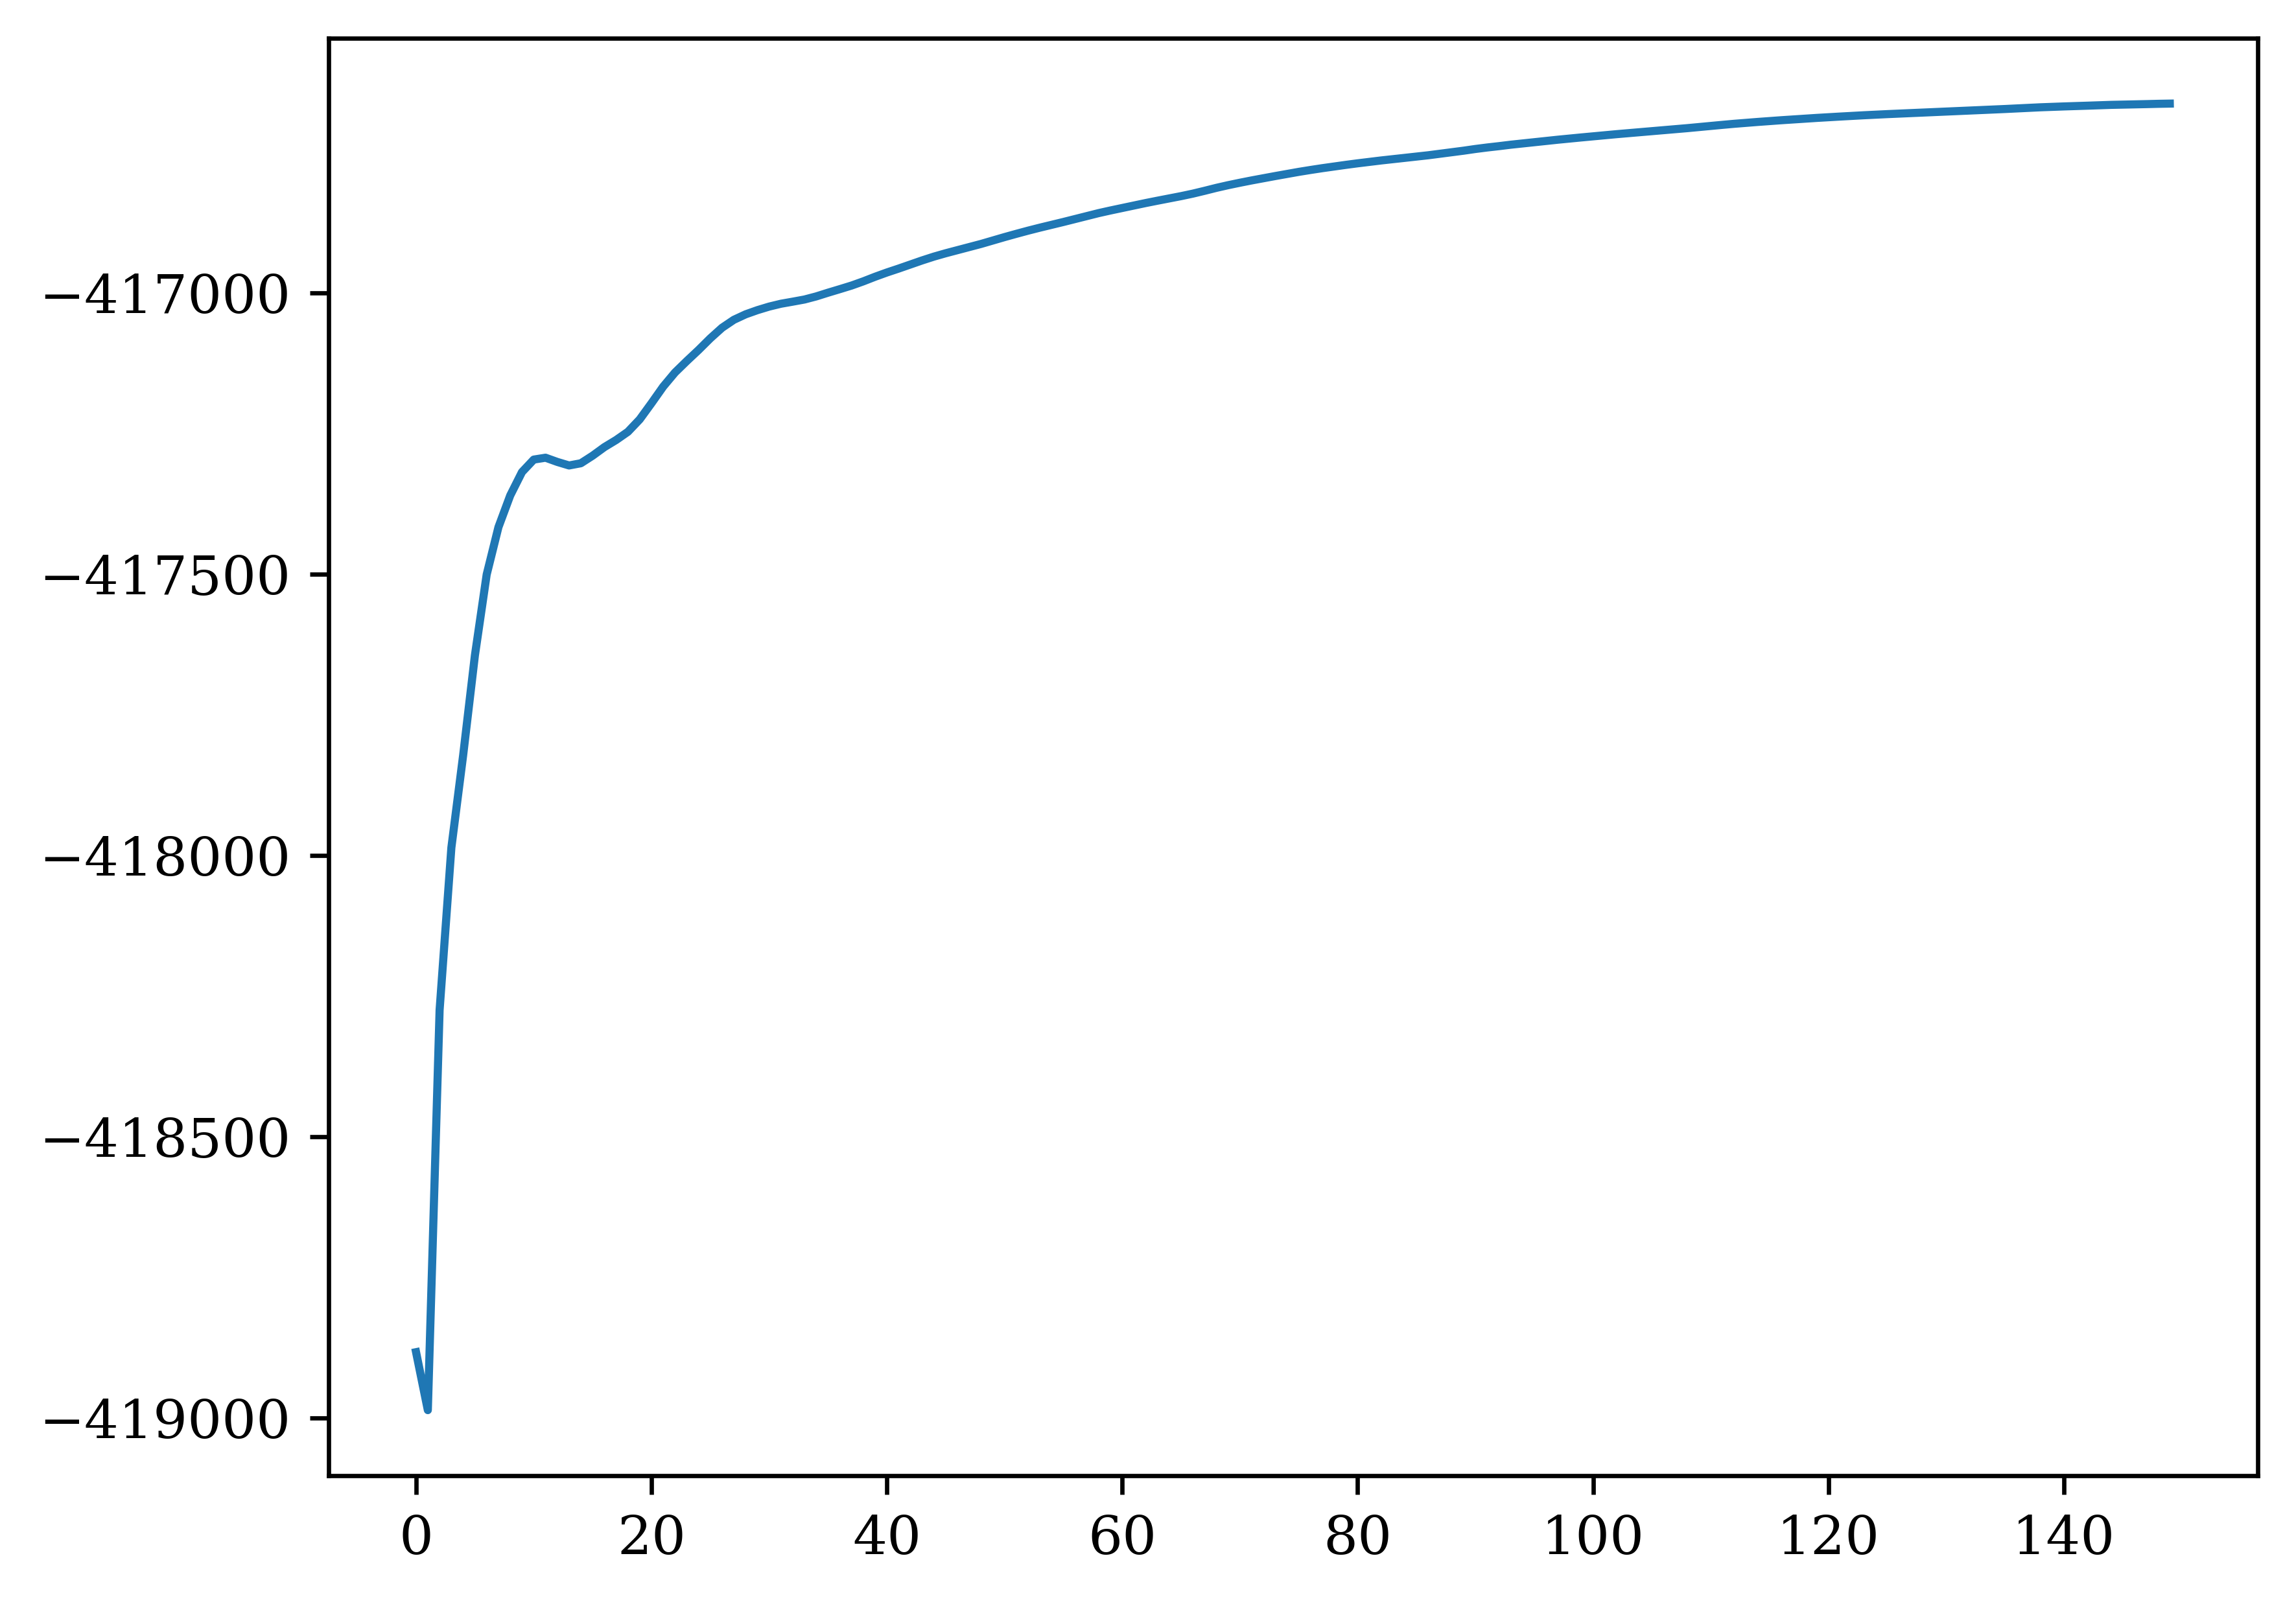

In [235]:
plt.plot(-loss)

Text(0.5, 0, 'Syllables')

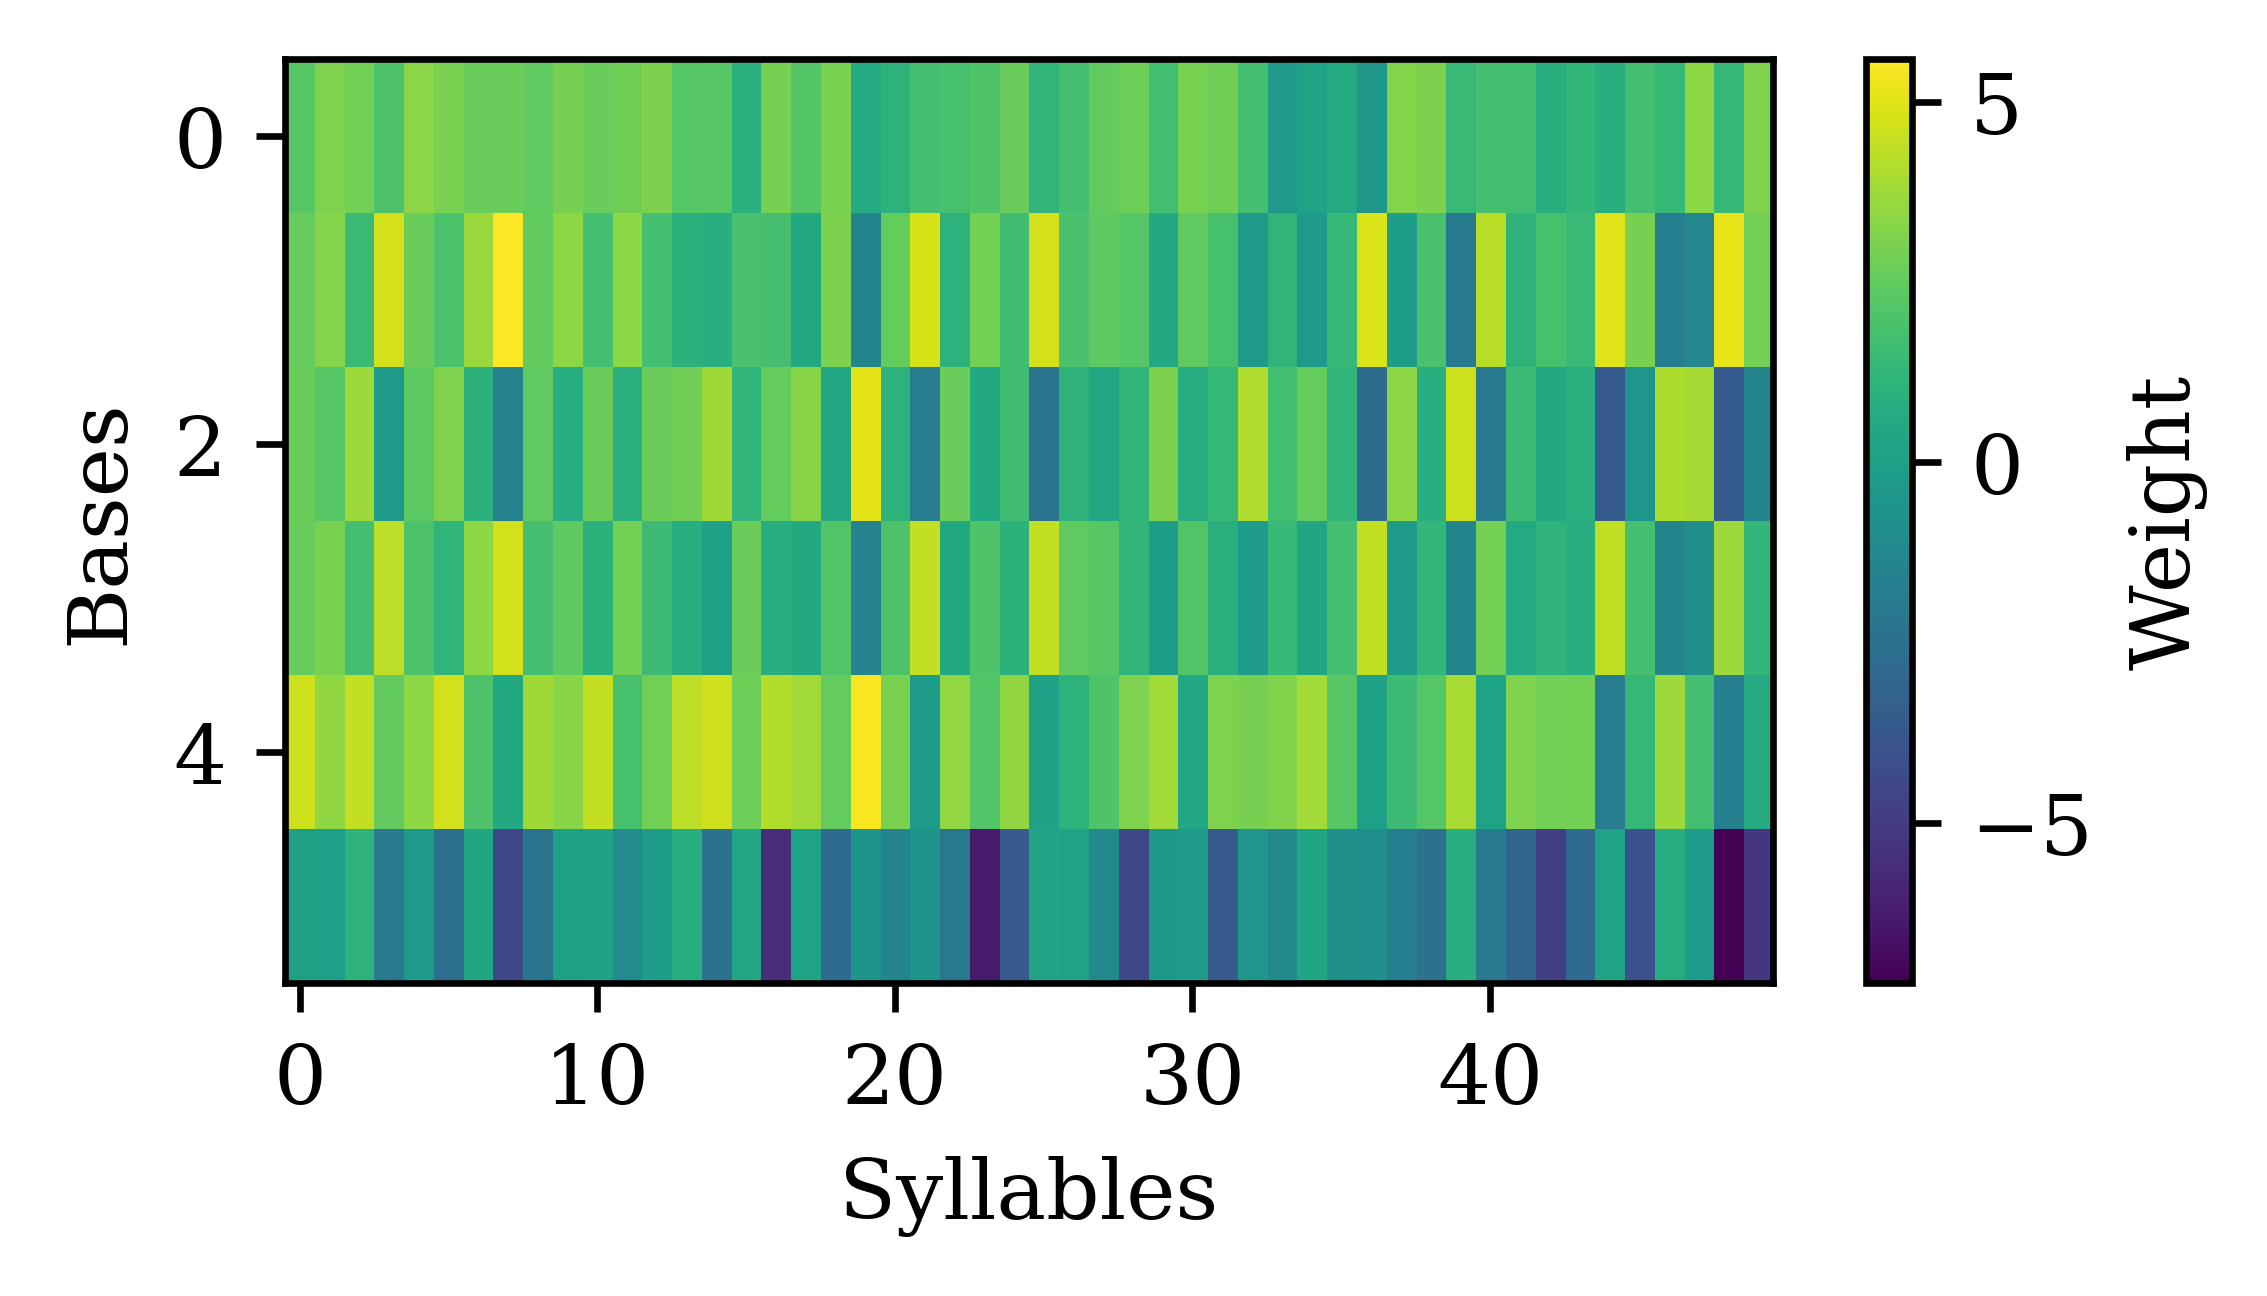

In [236]:
figure(4, 2)
plt.imshow(optimized_params['basis_weights'].T, aspect='auto')
plt.colorbar(label="Weight")
plt.ylabel("Bases")
plt.xlabel("Syllables")

In [239]:
results = np.exp(vectorized_biological_age(bases, optimized_params['basis_weights']))

Text(0.5, 0, 'Age (weeks)')

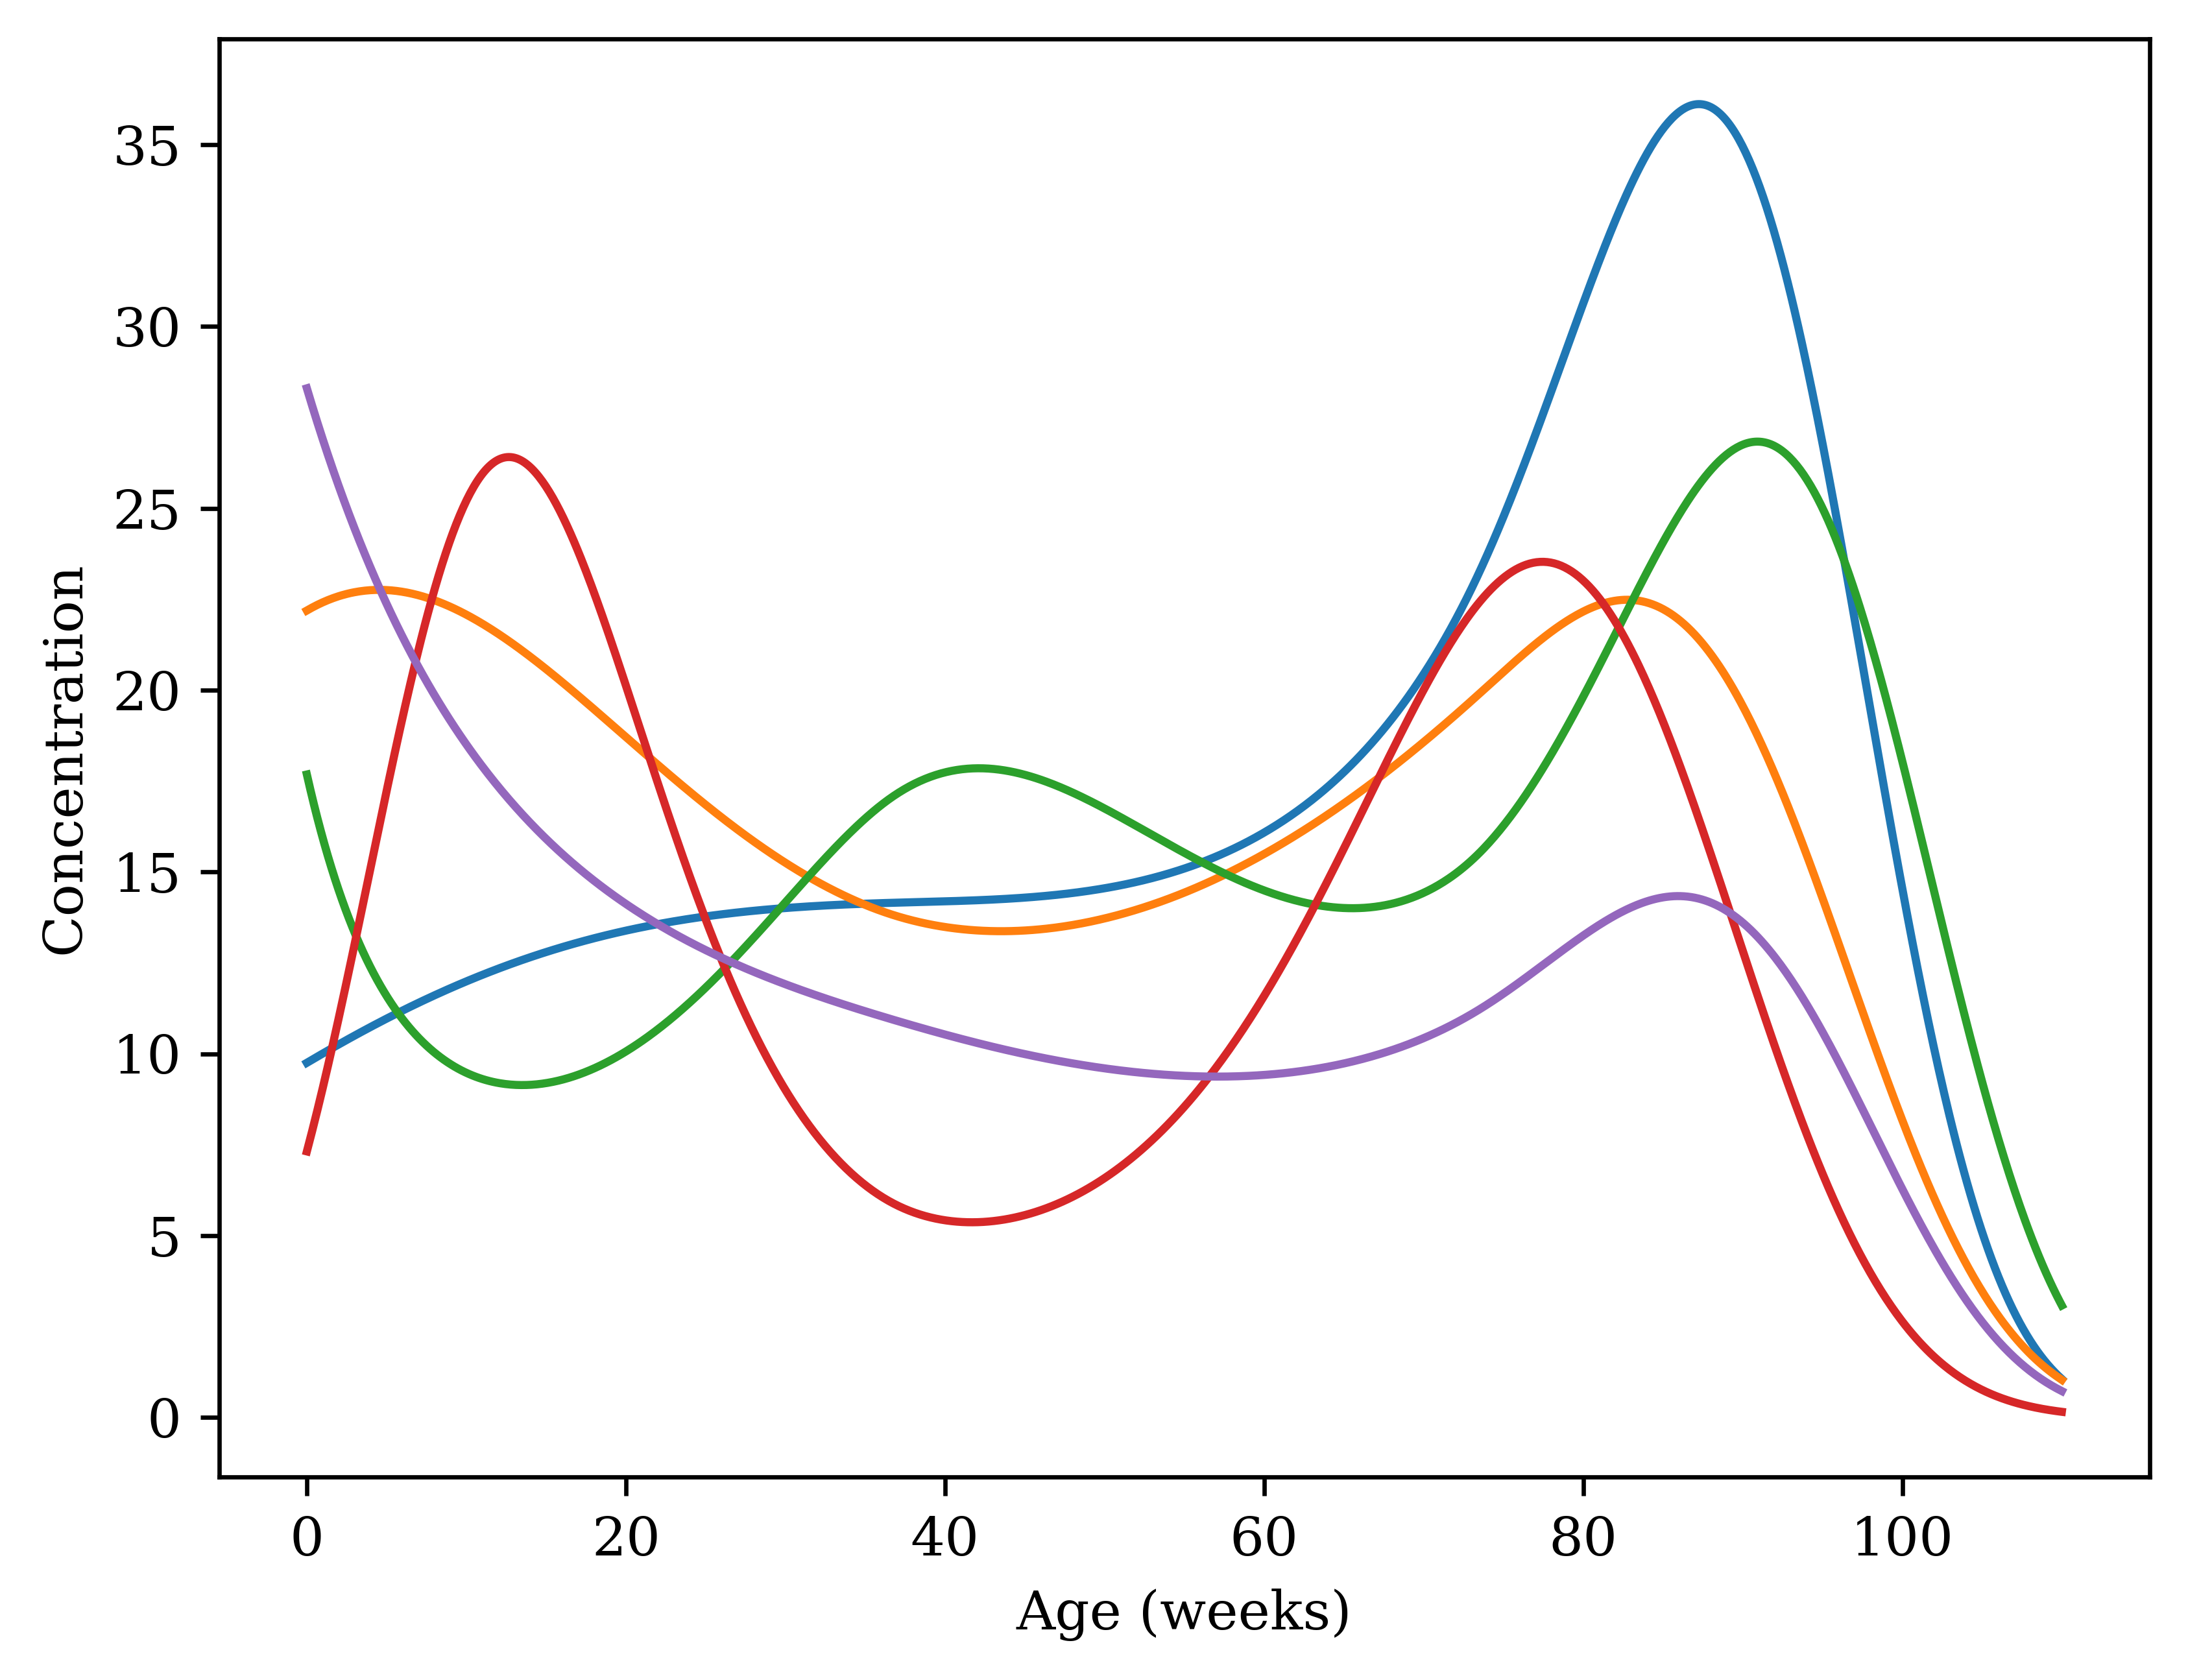

In [240]:
# for original model, it's results[:, :5]
plt.plot(np.linspace(0, 110, 1000), results[:5].T)
plt.ylabel("Concentration")
plt.xlabel("Age (weeks)")